In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
import scipy.stats as sts

from pyMFI import MFI

from matplotlib import rc

plt.rcParams.update({
    "font.size": 18,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"],    
})

# define custom color scheme
colors = [plt.cm.Spectral(i/float(10-1)) for i in range(10)]

cs = {
    "Bordeaux": colors[0],
    "Light Red": colors[1],
    "Orange": colors[2],
    "Gold": colors[3],
    "Yellow": colors[4],
    "Lime": colors[5],
    "Light Green": colors[6],
    "Teal": colors[7],
    "Blue": colors[8],
    "Purple": colors[9]
}

kT=8.314462618e-3*1100

# 2D Data Analysis

## L2 1

In [2]:
path = "Convergence_L2/"

n_simulations = 100
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]


for sim in range(1,11):
    for ulation in range(10):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")   
    
                                     
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        maxx=(np.max(position_x))
        minx=(np.min(position_x))
        maxy=(np.max(position_y))
        miny=(np.min(position_y))    
        #COMPUTE Mean force and weight of the simulation
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.03,0.03], error_pace = int(len(HILLS)/10), 
                            base_terms = master_patch[-1], nhills=-1, min_grid=[minx, miny], max_grid=[maxx, maxy], FES_cutoff = -1, use_weighted_st_dev=False)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
        
    
        # store forces for bootstrap analysis     
        forces_all.append([Ftot_den, Ftot_x, Ftot_y])
        #store results in master_array
        master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
        #patch master and store result in master_patch
        master_patch.append(MFI.patch_2D(master))
        #save ofe history and time
        ofe_history_patch += ofe_history
        time_history_patch += [element+time_history_patch[-1] for element in time_history]


|**************************************************| 100% | Average Mean Force Error: 10.529
|**************************************************| 100% | Average Mean Force Error: 12.226
|**************************************************| 100% | Average Mean Force Error: 8.586
|**************************************************| 100% | Average Mean Force Error: 5.329
|**************************************************| 100% | Average Mean Force Error: 5.436
|**************************************************| 100% | Average Mean Force Error: 5.053
|**************************************************| 100% | Average Mean Force Error: 4.964
|**************************************************| 100% | Average Mean Force Error: 4.718
|**************************************************| 100% | Average Mean Force Error: 4.635
|**************************************************| 100% | Average Mean Force Error: 4.578
|**************************************************| 100% | Average Mean Forc

In [3]:
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration 
[X, Y, FES_L2_1] = MFI.intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=[-0.5,-0.5], max_grid=[1.5, 1.5])

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-0.5, -0.5], [1.5, 1.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]

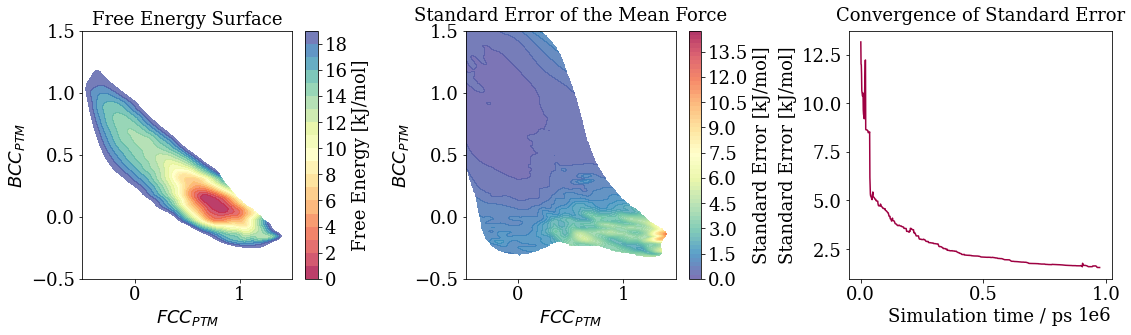

In [4]:
plot_FES =  MFI.zero_to_nan(FES_L2_1*cutoff)
TOTAL_DENSITY = MFI.zero_to_nan(master_patch[-1][0]*cutoff)
CONVMAP = MFI.zero_to_nan(ofe*cutoff)
CONV_history= ofe_history_patch
CONV_history_time = time_history_patch
FES_lim=20
ofe_map_lim=6
use_weighted_st_dev=False
FES_step=1
ofe_map_lim=15
ofe_step=0.25

fig, axs = plt.subplots(1,3, figsize=(16,5))

cp = axs[0].contourf(Y, X, plot_FES.T, levels=range(0, FES_lim, FES_step), cmap='Spectral', antialiased=False, alpha=0.8)
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("Free Energy [kJ/mol]", fontsize=18)
axs[0].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[0].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5,1.5)
axs[0].set_title('Free Energy Surface', fontsize=18)

cp = axs[1].contourf(Y, X, MFI.zero_to_nan(CONVMAP).T, levels=np.arange(0, ofe_map_lim, ofe_step), cmap='Spectral_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("Standard Deviation [kJ/mol]", fontsize=11) if use_weighted_st_dev==True else cbar.set_label("Standard Error [kJ/mol]", fontsize=18)
axs[1].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[1].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5,1.5)
axs[1].set_title('Standard Error of the Mean Force', fontsize=18, pad=10)


axs[2].plot( CONV_history_time, CONV_history, label="global ofe", color=cs["Bordeaux"]);
axs[2].set_ylabel('Standard Error [kJ/mol]', fontsize=18)
axs[2].set_xlabel('Simulation time / ps', fontsize=18)
axs[2].set_title('Convergence of Standard Error', fontsize=18, pad=10)

    
plt.tight_layout()
#plt.savefig("Figs_paper/Fs_L2_1_overview.png", dpi=500)

In [8]:
positions_x_L2_1 = np.empty(0)
positions_y_L2_1 = np.empty(0)

analyticals_x_L2_1 = np.empty(0)
analyticals_y_L2_1 = np.empty(0)
analyticals_z_L2_1 = np.empty(0)

weights_L2_1 = np.empty(0)
weights_pure_L2_1 = np.empty(0)

corrs_L2_1 = np.empty(0)

for sim in range(1,11):
    for ulation in range(10):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")
        # #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        NH0 = len(HILLS)
        #Read bias and analytical variables
        bias = np.loadtxt(sim_path + "colvar.out")[:,3]
        geo_corr = np.loadtxt(sim_path + "grads_corr.dat")
        analytical_xyz = np.loadtxt(sim_path + "PTM_labels.dat")[:,:3]/500
        analytical_x = analytical_xyz[:,1]
        analytical_y = analytical_xyz[:,0]
        analytical_z = analytical_xyz[:,2]
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        
        #Compute c(t) and sample weights_L2_1
        [expC,BIAS2Dfinal]=MFI.coft(HILLS=HILLS,FES=FES_L2_1,kT=kT,total_number_of_hills=NH0,stride=4,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
        c=kT*np.log(expC)
        weightsMETAD=np.exp(bias[:4*NH0-3]/kT-c/kT)*geo_corr[:4*NH0-3]
        weights_p = np.exp(bias[:4*NH0-3]/kT-c/kT)
        positions_x_L2_1 = np.concatenate([positions_x_L2_1,position_x[:4*NH0-3]])
        positions_y_L2_1 = np.concatenate([positions_y_L2_1,position_y[:4*NH0-3]])         
        analyticals_x_L2_1 = np.concatenate([analyticals_x_L2_1,analytical_x[:4*NH0-3]])
        analyticals_y_L2_1 = np.concatenate([analyticals_y_L2_1,analytical_y[:4*NH0-3]])
        analyticals_z_L2_1 = np.concatenate([analyticals_z_L2_1,analytical_z[:4*NH0-3]])

        weights_L2_1 = np.concatenate([weights_L2_1,NH0*weightsMETAD])
        weights_pure_L2_1 = np.concatenate([weights_pure_L2_1,NH0*weights_p])
        corrs_L2_1 = np.concatenate([corrs_L2_1, geo_corr])


|**************************************************| 99% | exp(c(t)/kT): 1.0430351817475845
|**************************************************| 99% | exp(c(t)/kT): 1.0983642632163255
|**************************************************| 99% | exp(c(t)/kT): 1.0505372244591473
|**************************************************| 99% | exp(c(t)/kT): 1.3376190715270562
|**************************************************| 99% | exp(c(t)/kT): 1.0936351397935045
|**************************************************| 99% | exp(c(t)/kT): 1.0962750077534842
|**************************************************| 99% | exp(c(t)/kT): 1.4212871248662504
|**************************************************| 99% | exp(c(t)/kT): 1.0788715630814545
|**************************************************| 99% | exp(c(t)/kT): 1.5336423201437088
|**************************************************| 99% | exp(c(t)/kT): 1.0860445845969013
|**************************************************| 99% | exp(c(t)/kT): 1.0315

In [9]:
np.savetxt("Data_paper/L2_1_positions_x.dat", positions_x_L2_1)
np.savetxt("Data_paper/L2_1_positions_y.dat", positions_y_L2_1)

np.savetxt("Data_paper/L2_1_analyticals_x.dat", analyticals_x_L2_1)
np.savetxt("Data_paper/L2_1_analyticals_y.dat", analyticals_y_L2_1)
np.savetxt("Data_paper/L2_1_analyticals_z.dat", analyticals_z_L2_1)

np.savetxt("Data_paper/L2_1_weights.dat", weights_L2_1)
np.savetxt("Data_paper/L2_1_corrs.dat", corrs_L2_1)

In [10]:
#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PGL2_1_a,XGL2_1_a,YGL2_1_a]=np.histogram2d(positions_x_L2_1, positions_y_L2_1,bins=50,weights=weights_pure_L2_1)
PGL2_1_a = PGL2_1_a.T
FGL2_1_a = -kT*np.log(PGL2_1_a)-np.min(-kT*np.log(PGL2_1_a))

[PGL2_1,XGL2_1,YGL2_1]=np.histogram2d(positions_x_L2_1, positions_y_L2_1,bins=50,weights=weights_L2_1)
PGL2_1 = PGL2_1.T
FGL2_1 = -kT*np.log(PGL2_1)-np.min(-kT*np.log(PGL2_1))

#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PreweL2_1,XreweL2_1,YreweL2_1]=np.histogram2d(analyticals_x_L2_1, analyticals_y_L2_1,bins=50,weights=weights_L2_1)
PreweL2_1 = PreweL2_1.T
FreweL2_1 = -kT*np.log(PreweL2_1)-np.min(-kT*np.log(PreweL2_1))

/tmp/ipykernel_16146/2824129291.py:4: RuntimeWarning: divide by zero encountered in log
  FGL2_1_a = -kT*np.log(PGL2_1_a)-np.min(-kT*np.log(PGL2_1_a))
/tmp/ipykernel_16146/2824129291.py:8: RuntimeWarning: divide by zero encountered in log
  FGL2_1 = -kT*np.log(PGL2_1)-np.min(-kT*np.log(PGL2_1))
/tmp/ipykernel_16146/2824129291.py:13: RuntimeWarning: divide by zero encountered in log
  FreweL2_1 = -kT*np.log(PreweL2_1)-np.min(-kT*np.log(PreweL2_1))


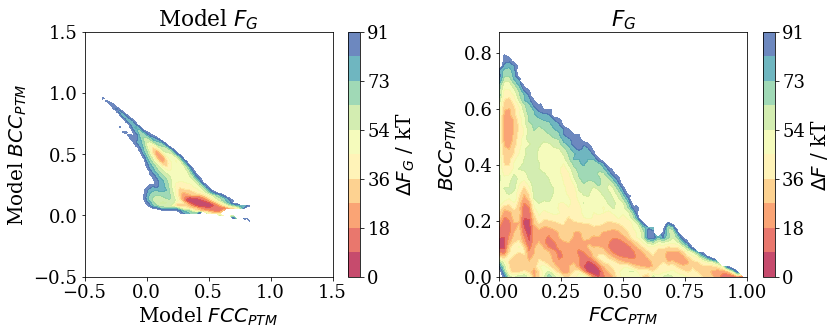

In [11]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

cp = axs[0].contourf(YGL2_1[:-1], XGL2_1[:-1], FGL2_1.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(XreweL2_1[:-1], YreweL2_1[:-1], FreweL2_1, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[1].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(np.min(XreweL2_1),np.max(XreweL2_1))
axs[1].set_ylim(np.min(YreweL2_1),np.max(YreweL2_1))
axs[1].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/L2_1_2DFES.png", dpi=500)

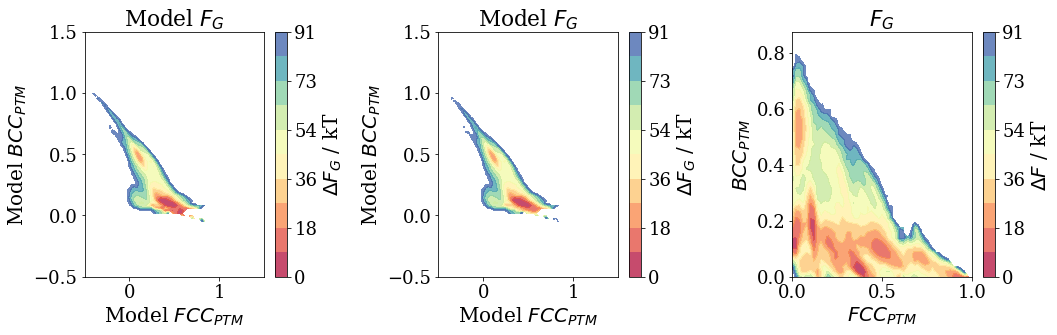

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

cp = axs[0].contourf(YGL2_1_a[:-1], XGL2_1_a[:-1], FGL2_1_a.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(YGL2_1[:-1], XGL2_1[:-1], FGL2_1.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[1].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_title("Model $F_G$")

cp = axs[2].contourf(XreweL2_1[:-1], YreweL2_1[:-1], FreweL2_1, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[2].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[2].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[2].set_xlim(np.min(XreweL2_1),np.max(XreweL2_1))
axs[2].set_ylim(np.min(YreweL2_1),np.max(YreweL2_1))
axs[2].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/L2_1_2DFES_sanity.png", dpi=500)

## L2 2

In [13]:
path = "Convergence_L2_2/"

n_simulations = 100
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]


for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")   
    
                                     
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        maxx=(np.max(position_x))
        minx=(np.min(position_x))
        maxy=(np.max(position_y))
        miny=(np.min(position_y))    
        #COMPUTE Mean force and weight of the simulation
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.03,0.03], error_pace = int(len(HILLS)/10), 
                            base_terms = master_patch[-1], nhills=-1, min_grid=[minx, miny], max_grid=[maxx, maxy], FES_cutoff = -1, use_weighted_st_dev=False)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
        
    
        # store forces for bootstrap analysis     
        forces_all.append([Ftot_den, Ftot_x, Ftot_y])
        #store results in master_array
        master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
        #patch master and store result in master_patch
        master_patch.append(MFI.patch_2D(master))
        #save ofe history and time
        ofe_history_patch += ofe_history
        time_history_patch += [element+time_history_patch[-1] for element in time_history]


|**************************************************| 100% | Average Mean Force Error: 6.001
|**************************************************| 100% | Average Mean Force Error: 5.27
|**************************************************| 100% | Average Mean Force Error: 5.18
|**************************************************| 100% | Average Mean Force Error: 5.01
|**************************************************| 100% | Average Mean Force Error: 4.387
|**************************************************| 100% | Average Mean Force Error: 4.324
|**************************************************| 100% | Average Mean Force Error: 4.297
|**************************************************| 100% | Average Mean Force Error: 3.82
|**************************************************| 100% | Average Mean Force Error: 3.62
|**************************************************| 100% | Average Mean Force Error: 3.551
|**************************************************| 100% | Average Mean Force Error

In [14]:
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration 
[X, Y, FES_L2_2] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=[-0.5,-0.5], max_grid=[1.5, 1.5])

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-0.5, -0.5], [1.5, 1.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]

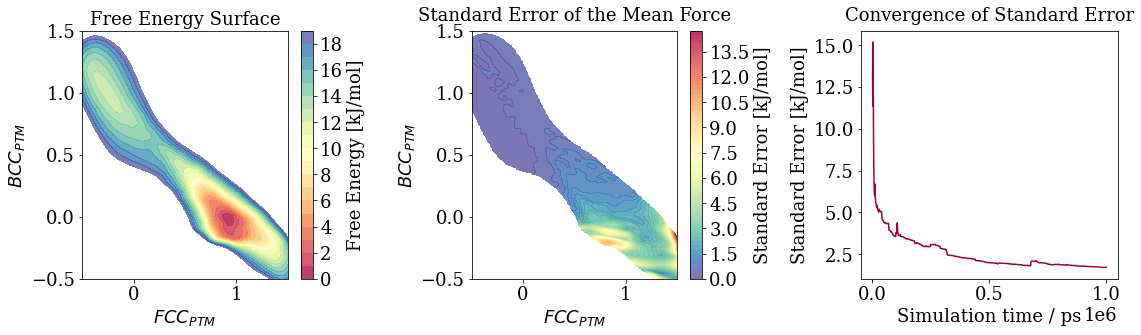

In [15]:
plot_FES =  MFI.zero_to_nan(FES_L2_2*cutoff)
TOTAL_DENSITY = MFI.zero_to_nan(master_patch[-1][0]*cutoff)
CONVMAP = MFI.zero_to_nan(ofe*cutoff)
CONV_history= ofe_history_patch
CONV_history_time = time_history_patch
FES_lim=20
ofe_map_lim=6
use_weighted_st_dev=False
FES_step=1
ofe_map_lim=15
ofe_step=0.25

fig, axs = plt.subplots(1,3, figsize=(16,5))

cp = axs[0].contourf(Y, X, plot_FES.T, levels=range(0, FES_lim, FES_step), cmap='Spectral', antialiased=False, alpha=0.8)
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("Free Energy [kJ/mol]", fontsize=18)
axs[0].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[0].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5,1.5)
axs[0].set_title('Free Energy Surface', fontsize=18)

cp = axs[1].contourf(Y, X, MFI.zero_to_nan(CONVMAP).T, levels=np.arange(0, ofe_map_lim, ofe_step), cmap='Spectral_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("Standard Deviation [kJ/mol]", fontsize=11) if use_weighted_st_dev==True else cbar.set_label("Standard Error [kJ/mol]", fontsize=18)
axs[1].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[1].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5,1.5)
axs[1].set_title('Standard Error of the Mean Force', fontsize=18, pad=10)


axs[2].plot( CONV_history_time, CONV_history, label="global ofe", color=cs["Bordeaux"]);
axs[2].set_ylabel('Standard Error [kJ/mol]', fontsize=18)
axs[2].set_xlabel('Simulation time / ps', fontsize=18)
axs[2].set_title('Convergence of Standard Error', fontsize=18, pad=10)

    
plt.tight_layout()
plt.savefig("Figs_paper/Fs_L2_2_overview.png", dpi=500)

In [17]:
positions_x_L2_2 = np.empty(0)
positions_y_L2_2 = np.empty(0)

analyticals_x_L2_2 = np.empty(0)
analyticals_y_L2_2 = np.empty(0)
analyticals_z_L2_2 = np.empty(0)

weights_L2_2 = np.empty(0)
weights_pure_L2_2 = np.empty(0)

corrs_L2_2 = np.empty(0)

for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")
        # #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        NH0 = len(HILLS)
        #Read bias and analytical variables
        bias = np.loadtxt(sim_path + "colvar.out")[:,3]
        geo_corr = np.loadtxt(sim_path + "grads_corr.dat")
        analytical_xyz = np.loadtxt(sim_path + "PTM_labels.dat")[:,:3]/500
        analytical_x = analytical_xyz[:,1]
        analytical_y = analytical_xyz[:,0]
        analytical_z = analytical_xyz[:,2]
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        
        #Compute c(t) and sample weights_L2_2
        [expC,BIAS2Dfinal]=MFI.coft(HILLS=HILLS,FES=FES_L2_2,kT=kT,total_number_of_hills=NH0,stride=4,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
        c=kT*np.log(expC)
        weightsMETAD=np.exp(bias[:4*NH0-3]/kT-c/kT)*geo_corr[:4*NH0-3]
        weights_p = np.exp(bias[:4*NH0-3]/kT-c/kT)
        positions_x_L2_2 = np.concatenate([positions_x_L2_2,position_x[:4*NH0-3]])
        positions_y_L2_2 = np.concatenate([positions_y_L2_2,position_y[:4*NH0-3]])         
        analyticals_x_L2_2 = np.concatenate([analyticals_x_L2_2,analytical_x[:4*NH0-3]])
        analyticals_y_L2_2 = np.concatenate([analyticals_y_L2_2,analytical_y[:4*NH0-3]])
        analyticals_z_L2_2 = np.concatenate([analyticals_z_L2_2,analytical_z[:4*NH0-3]])

        weights_L2_2 = np.concatenate([weights_L2_2,NH0*weightsMETAD])
        weights_pure_L2_2 = np.concatenate([weights_pure_L2_2,NH0*weights_p])
        corrs_L2_2 = np.concatenate([corrs_L2_2, geo_corr])


|**************************************************| 99% | exp(c(t)/kT): 1.4664186908138157
|**************************************************| 99% | exp(c(t)/kT): 1.1279416825571773
|**************************************************| 99% | exp(c(t)/kT): 1.2899857477731527
|**************************************************| 99% | exp(c(t)/kT): 1.1449162689761339
|**************************************************| 99% | exp(c(t)/kT): 1.3544539863656882
|**************************************************| 99% | exp(c(t)/kT): 1.2332357620769923
|**************************************************| 99% | exp(c(t)/kT): 1.3466281659824635
|**************************************************| 99% | exp(c(t)/kT): 1.3343413079661216
|**************************************************| 99% | exp(c(t)/kT): 1.3487669911768056
|**************************************************| 99% | exp(c(t)/kT): 1.1636055951061526
|**************************************************| 99% | exp(c(t)/kT): 1.4392

In [18]:
np.savetxt("Data_paper/L2_2_positions_x.dat", positions_x_L2_2)
np.savetxt("Data_paper/L2_2_positions_y.dat", positions_y_L2_2)

np.savetxt("Data_paper/L2_2_analyticals_x.dat", analyticals_x_L2_2)
np.savetxt("Data_paper/L2_2_analyticals_y.dat", analyticals_y_L2_2)
np.savetxt("Data_paper/L2_2_analyticals_z.dat", analyticals_z_L2_2)

np.savetxt("Data_paper/L2_2_weights.dat", weights_L2_2)
np.savetxt("Data_paper/L2_2_corrs.dat", corrs_L2_2)

In [19]:
#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PGL2_2_a,XGL2_2_a,YGL2_2_a]=np.histogram2d(positions_x_L2_2, positions_y_L2_2,bins=50,weights=weights_pure_L2_2)
PGL2_2_a = PGL2_2_a.T
FGL2_2_a = -kT*np.log(PGL2_2_a)-np.min(-kT*np.log(PGL2_2_a))

[PGL2_2,XGL2_2,YGL2_2]=np.histogram2d(positions_x_L2_2, positions_y_L2_2,bins=50,weights=weights_L2_2)
PGL2_2 = PGL2_2.T
FGL2_2 = -kT*np.log(PGL2_2)-np.min(-kT*np.log(PGL2_2))

#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PreweL2_2,XreweL2_2,YreweL2_2]=np.histogram2d(analyticals_x_L2_2, analyticals_y_L2_2,bins=50,weights=weights_L2_2)
PreweL2_2 = PreweL2_2.T
FreweL2_2 = -kT*np.log(PreweL2_2)-np.min(-kT*np.log(PreweL2_2))

/tmp/ipykernel_16146/4270967753.py:4: RuntimeWarning: divide by zero encountered in log
  FGL2_2_a = -kT*np.log(PGL2_2_a)-np.min(-kT*np.log(PGL2_2_a))
/tmp/ipykernel_16146/4270967753.py:8: RuntimeWarning: divide by zero encountered in log
  FGL2_2 = -kT*np.log(PGL2_2)-np.min(-kT*np.log(PGL2_2))
/tmp/ipykernel_16146/4270967753.py:13: RuntimeWarning: divide by zero encountered in log
  FreweL2_2 = -kT*np.log(PreweL2_2)-np.min(-kT*np.log(PreweL2_2))


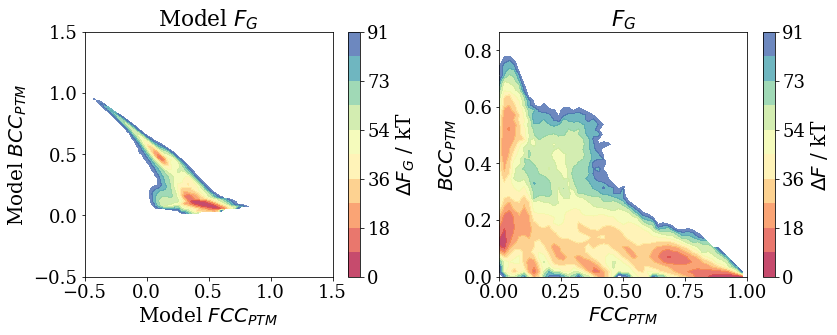

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

cp = axs[0].contourf(YGL2_2[:-1], XGL2_2[:-1], FGL2_2.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(XreweL2_2[:-1], YreweL2_2[:-1], FreweL2_2, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[1].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(np.min(XreweL2_2),np.max(XreweL2_2))
axs[1].set_ylim(np.min(YreweL2_2),np.max(YreweL2_2))
axs[1].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/L2_2_2DFES.png", dpi=500)

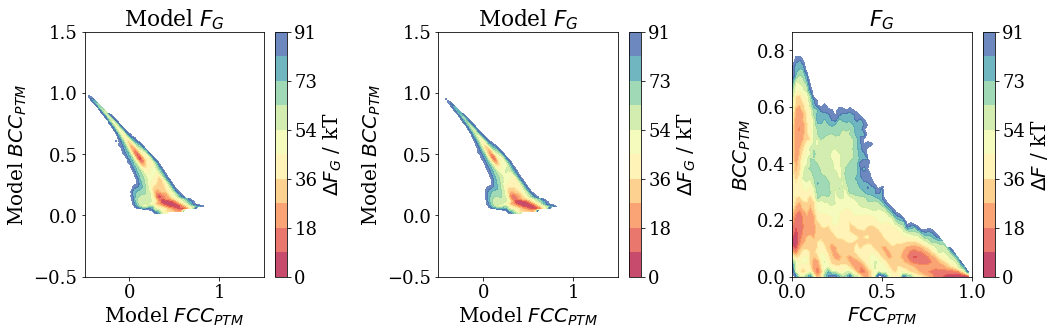

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

cp = axs[0].contourf(YGL2_2_a[:-1], XGL2_2_a[:-1], FGL2_2_a.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(YGL2_2[:-1], XGL2_2[:-1], FGL2_2.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[1].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_title("Model $F_G$")

cp = axs[2].contourf(XreweL2_2[:-1], YreweL2_2[:-1], FreweL2_2, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[2].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[2].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[2].set_xlim(np.min(XreweL2_2),np.max(XreweL2_2))
axs[2].set_ylim(np.min(YreweL2_2),np.max(YreweL2_2))
axs[2].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/L2_2_2DFES_sanity.png", dpi=500)

## L2 3

In [22]:
path = "Convergence_L2_3/"

n_simulations = 100
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]


for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")   
    
                                     
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        maxx=(np.max(position_x))
        minx=(np.min(position_x))
        maxy=(np.max(position_y))
        miny=(np.min(position_y))    
        #COMPUTE Mean force and weight of the simulation
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.03,0.03], error_pace = int(len(HILLS)/10), 
                            base_terms = master_patch[-1], nhills=-1, min_grid=[minx, miny], max_grid=[maxx, maxy], FES_cutoff = -1, use_weighted_st_dev=False)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
        
    
        # store forces for bootstrap analysis     
        forces_all.append([Ftot_den, Ftot_x, Ftot_y])
        #store results in master_array
        master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
        #patch master and store result in master_patch
        master_patch.append(MFI.patch_2D(master))
        #save ofe history and time
        ofe_history_patch += ofe_history
        time_history_patch += [element+time_history_patch[-1] for element in time_history]


|**************************************************| 100% | Average Mean Force Error: 5.574
|**************************************************| 100% | Average Mean Force Error: 4.821
|**************************************************| 100% | Average Mean Force Error: 4.189
|**************************************************| 100% | Average Mean Force Error: 4.508
|**************************************************| 100% | Average Mean Force Error: 4.249
|**************************************************| 100% | Average Mean Force Error: 4.076
|**************************************************| 100% | Average Mean Force Error: 4.213
|**************************************************| 100% | Average Mean Force Error: 4.023
|**************************************************| 100% | Average Mean Force Error: 3.93
|**************************************************| 100% | Average Mean Force Error: 9.828
|**************************************************| 100% | Average Mean Force E

In [23]:
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration 
[X, Y, FES_L2_3] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=[-0.5,-0.5], max_grid=[1.5, 1.5])

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-0.5, -0.5], [1.5, 1.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]

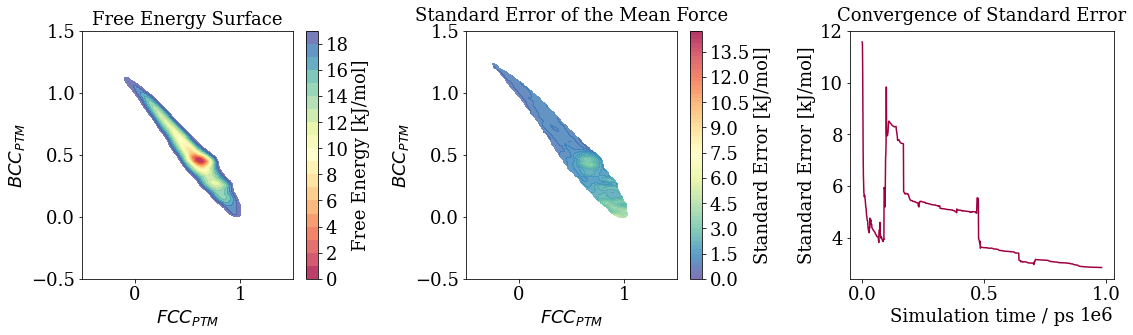

In [24]:
plot_FES =  MFI.zero_to_nan(FES_L2_3*cutoff)
TOTAL_DENSITY = MFI.zero_to_nan(master_patch[-1][0]*cutoff)
CONVMAP = MFI.zero_to_nan(ofe*cutoff)
CONV_history= ofe_history_patch
CONV_history_time = time_history_patch
FES_lim=20
ofe_map_lim=6
use_weighted_st_dev=False
FES_step=1
ofe_map_lim=15
ofe_step=0.25

fig, axs = plt.subplots(1,3, figsize=(16,5))

cp = axs[0].contourf(Y, X, plot_FES.T, levels=range(0, FES_lim, FES_step), cmap='Spectral', antialiased=False, alpha=0.8)
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("Free Energy [kJ/mol]", fontsize=18)
axs[0].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[0].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5,1.5)
axs[0].set_title('Free Energy Surface', fontsize=18)

cp = axs[1].contourf(Y, X, MFI.zero_to_nan(CONVMAP).T, levels=np.arange(0, ofe_map_lim, ofe_step), cmap='Spectral_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("Standard Deviation [kJ/mol]", fontsize=11) if use_weighted_st_dev==True else cbar.set_label("Standard Error [kJ/mol]", fontsize=18)
axs[1].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[1].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5,1.5)
axs[1].set_title('Standard Error of the Mean Force', fontsize=18, pad=10)


axs[2].plot( CONV_history_time, CONV_history, label="global ofe", color=cs["Bordeaux"]);
axs[2].set_ylabel('Standard Error [kJ/mol]', fontsize=18)
axs[2].set_xlabel('Simulation time / ps', fontsize=18)
axs[2].set_title('Convergence of Standard Error', fontsize=18, pad=10)

    
plt.tight_layout()
plt.savefig("Figs_paper/Fs_L2_3_overview.png", dpi=500)

In [25]:
positions_x_L2_3 = np.empty(0)
positions_y_L2_3 = np.empty(0)

analyticals_x_L2_3 = np.empty(0)
analyticals_y_L2_3 = np.empty(0)
analyticals_z_L2_3 = np.empty(0)

weights_L2_3 = np.empty(0)
weights_pure_L2_3 = np.empty(0)

corrs_L2_3 = np.empty(0)

for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")
        # #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        NH0 = len(HILLS)
        #Read bias and analytical variables
        bias = np.loadtxt(sim_path + "colvar.out")[:,3]
        geo_corr = np.loadtxt(sim_path + "grads_corr.dat")
        analytical_xyz = np.loadtxt(sim_path + "PTM_labels.dat")[:,:3]/500
        analytical_x = analytical_xyz[:,1]
        analytical_y = analytical_xyz[:,0]
        analytical_z = analytical_xyz[:,2]
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        
        #Compute c(t) and sample weights_L2_3
        [expC,BIAS2Dfinal]=MFI.coft(HILLS=HILLS,FES=FES_L2_3,kT=kT,total_number_of_hills=NH0,stride=4,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
        c=kT*np.log(expC)
        weightsMETAD=np.exp(bias[:4*NH0-3]/kT-c/kT)*geo_corr[:4*NH0-3]
        weights_p = np.exp(bias[:4*NH0-3]/kT-c/kT)
        positions_x_L2_3 = np.concatenate([positions_x_L2_3,position_x[:4*NH0-3]])
        positions_y_L2_3 = np.concatenate([positions_y_L2_3,position_y[:4*NH0-3]])         
        analyticals_x_L2_3 = np.concatenate([analyticals_x_L2_3,analytical_x[:4*NH0-3]])
        analyticals_y_L2_3 = np.concatenate([analyticals_y_L2_3,analytical_y[:4*NH0-3]])
        analyticals_z_L2_3 = np.concatenate([analyticals_z_L2_3,analytical_z[:4*NH0-3]])

        weights_L2_3 = np.concatenate([weights_L2_3,NH0*weightsMETAD])
        weights_pure_L2_3 = np.concatenate([weights_pure_L2_3,NH0*weights_p])
        corrs_L2_3 = np.concatenate([corrs_L2_3, geo_corr])


|**************************************************| 99% | exp(c(t)/kT): 1.3007399403127409
|**************************************************| 99% | exp(c(t)/kT): 1.4355888266346586
|**************************************************| 99% | exp(c(t)/kT): 1.2954844041683202
|**************************************************| 99% | exp(c(t)/kT): 1.4070641845980045
|**************************************************| 99% | exp(c(t)/kT): 1.3270074190727685
|**************************************************| 99% | exp(c(t)/kT): 1.3261805019402734
|**************************************************| 99% | exp(c(t)/kT): 1.3143107961119428
|**************************************************| 99% | exp(c(t)/kT): 1.4139513180999139
|**************************************************| 99% | exp(c(t)/kT): 1.1765218001431583
|**************************************************| 99% | exp(c(t)/kT): 1.4278483288997372
|**************************************************| 99% | exp(c(t)/kT): 1.3814

In [26]:
np.savetxt("Data_paper/L2_3_positions_x.dat", positions_x_L2_3)
np.savetxt("Data_paper/L2_3_positions_y.dat", positions_y_L2_3)

np.savetxt("Data_paper/L2_3_analyticals_x.dat", analyticals_x_L2_3)
np.savetxt("Data_paper/L2_3_analyticals_y.dat", analyticals_y_L2_3)
np.savetxt("Data_paper/L2_3_analyticals_z.dat", analyticals_z_L2_3)

np.savetxt("Data_paper/L2_3_weights.dat", weights_L2_3)
np.savetxt("Data_paper/L2_3_corrs.dat", corrs_L2_3)

In [27]:
#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PGL2_3_a,XGL2_3_a,YGL2_3_a]=np.histogram2d(positions_x_L2_3, positions_y_L2_3,bins=50,weights=weights_pure_L2_3)
PGL2_3_a = PGL2_3_a.T
FGL2_3_a = -kT*np.log(PGL2_3_a)-np.min(-kT*np.log(PGL2_3_a))

[PGL2_3,XGL2_3,YGL2_3]=np.histogram2d(positions_x_L2_3, positions_y_L2_3,bins=50,weights=weights_L2_3)
PGL2_3 = PGL2_3.T
FGL2_3 = -kT*np.log(PGL2_3)-np.min(-kT*np.log(PGL2_3))

#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PreweL2_3,XreweL2_3,YreweL2_3]=np.histogram2d(analyticals_x_L2_3, analyticals_y_L2_3,bins=50,weights=weights_L2_3)
PreweL2_3 = PreweL2_3.T
FreweL2_3 = -kT*np.log(PreweL2_3)-np.min(-kT*np.log(PreweL2_3))

/tmp/ipykernel_16146/3959014704.py:4: RuntimeWarning: divide by zero encountered in log
  FGL2_3_a = -kT*np.log(PGL2_3_a)-np.min(-kT*np.log(PGL2_3_a))
/tmp/ipykernel_16146/3959014704.py:8: RuntimeWarning: divide by zero encountered in log
  FGL2_3 = -kT*np.log(PGL2_3)-np.min(-kT*np.log(PGL2_3))
/tmp/ipykernel_16146/3959014704.py:13: RuntimeWarning: divide by zero encountered in log
  FreweL2_3 = -kT*np.log(PreweL2_3)-np.min(-kT*np.log(PreweL2_3))


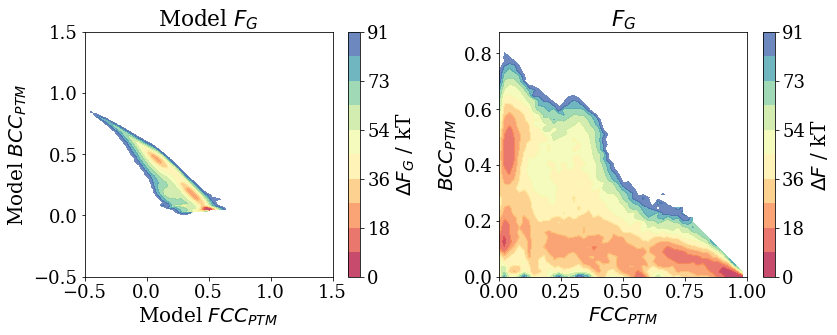

In [28]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

cp = axs[0].contourf(YGL2_3[:-1], XGL2_3[:-1], FGL2_3.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(XreweL2_3[:-1], YreweL2_3[:-1], FreweL2_3, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[1].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(np.min(XreweL2_3),np.max(XreweL2_3))
axs[1].set_ylim(np.min(YreweL2_3),np.max(YreweL2_3))
axs[1].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/L2_3_2DFES.png", dpi=500)

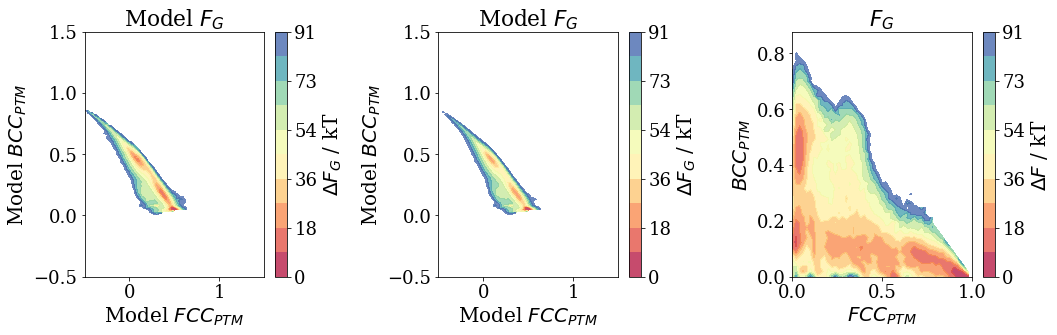

In [29]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

cp = axs[0].contourf(YGL2_3_a[:-1], XGL2_3_a[:-1], FGL2_3_a.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(YGL2_3[:-1], XGL2_3[:-1], FGL2_3.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[1].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_title("Model $F_G$")

cp = axs[2].contourf(XreweL2_3[:-1], YreweL2_3[:-1], FreweL2_3, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[2].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[2].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[2].set_xlim(np.min(XreweL2_3),np.max(XreweL2_3))
axs[2].set_ylim(np.min(YreweL2_3),np.max(YreweL2_3))
axs[2].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/L2_3_2DFES_sanity.png", dpi=500)

## CR 1

In [30]:
path = "Convergence_CR/"

n_simulations = 100
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]


for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")   
    
                                     
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        maxx=(np.max(position_x))
        minx=(np.min(position_x))
        maxy=(np.max(position_y))
        miny=(np.min(position_y))    
        #COMPUTE Mean force and weight of the simulation
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.03,0.03], error_pace = int(len(HILLS)/10), 
                            base_terms = master_patch[-1], nhills=-1, min_grid=[minx, miny], max_grid=[maxx, maxy], FES_cutoff = -1, use_weighted_st_dev=False)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
        
    
        # store forces for bootstrap analysis     
        forces_all.append([Ftot_den, Ftot_x, Ftot_y])
        #store results in master_array
        master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
        #patch master and store result in master_patch
        master_patch.append(MFI.patch_2D(master))
        #save ofe history and time
        ofe_history_patch += ofe_history
        time_history_patch += [element+time_history_patch[-1] for element in time_history]


|**************************************************| 100% | Average Mean Force Error: 11.53
|**************************************************| 100% | Average Mean Force Error: 7.45
|**************************************************| 100% | Average Mean Force Error: 5.359
|**************************************************| 100% | Average Mean Force Error: 4.656
|**************************************************| 100% | Average Mean Force Error: 4.605
|**************************************************| 100% | Average Mean Force Error: 4.214
|**************************************************| 100% | Average Mean Force Error: 3.612
|**************************************************| 100% | Average Mean Force Error: 3.426
|**************************************************| 100% | Average Mean Force Error: 3.034
|**************************************************| 100% | Average Mean Force Error: 2.968
|**************************************************| 100% | Average Mean Force E

In [31]:
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration 
[X, Y, FES_CR_1] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=[-0.5,-0.5], max_grid=[1.5, 1.5])

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-0.5, -0.5], [1.5, 1.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]

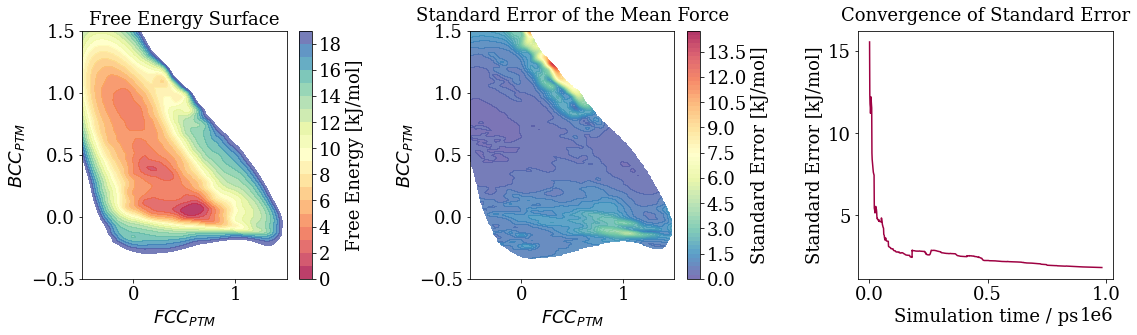

In [32]:
plot_FES =  MFI.zero_to_nan(FES_CR_1*cutoff)
TOTAL_DENSITY = MFI.zero_to_nan(master_patch[-1][0]*cutoff)
CONVMAP = MFI.zero_to_nan(ofe*cutoff)
CONV_history= ofe_history_patch
CONV_history_time = time_history_patch
FES_lim=20
ofe_map_lim=6
use_weighted_st_dev=False
FES_step=1
ofe_map_lim=15
ofe_step=0.25

fig, axs = plt.subplots(1,3, figsize=(16,5))

cp = axs[0].contourf(Y, X, plot_FES.T, levels=range(0, FES_lim, FES_step), cmap='Spectral', antialiased=False, alpha=0.8)
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("Free Energy [kJ/mol]", fontsize=18)
axs[0].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[0].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5,1.5)
axs[0].set_title('Free Energy Surface', fontsize=18)

cp = axs[1].contourf(Y, X, MFI.zero_to_nan(CONVMAP).T, levels=np.arange(0, ofe_map_lim, ofe_step), cmap='Spectral_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("Standard Deviation [kJ/mol]", fontsize=11) if use_weighted_st_dev==True else cbar.set_label("Standard Error [kJ/mol]", fontsize=18)
axs[1].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[1].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5,1.5)
axs[1].set_title('Standard Error of the Mean Force', fontsize=18, pad=10)


axs[2].plot( CONV_history_time, CONV_history, label="global ofe", color=cs["Bordeaux"]);
axs[2].set_ylabel('Standard Error [kJ/mol]', fontsize=18)
axs[2].set_xlabel('Simulation time / ps', fontsize=18)
axs[2].set_title('Convergence of Standard Error', fontsize=18, pad=10)

    
plt.tight_layout()
plt.savefig("Figs_paper/Fs_CR_1_overview.png", dpi=500)

In [33]:
positions_x_CR_1 = np.empty(0)
positions_y_CR_1 = np.empty(0)

analyticals_x_CR_1 = np.empty(0)
analyticals_y_CR_1 = np.empty(0)
analyticals_z_CR_1 = np.empty(0)

weights_CR_1 = np.empty(0)
weights_pure_CR_1 = np.empty(0)

corrs_CR_1 = np.empty(0)

for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")
        # #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        NH0 = len(HILLS)
        #Read bias and analytical variables
        bias = np.loadtxt(sim_path + "colvar.out")[:,3]
        geo_corr = np.loadtxt(sim_path + "grads_corr.dat")
        analytical_xyz = np.loadtxt(sim_path + "PTM_labels.dat")[:,:3]/500
        analytical_x = analytical_xyz[:,1]
        analytical_y = analytical_xyz[:,0]
        analytical_z = analytical_xyz[:,2]
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        
        #Compute c(t) and sample weights_CR_1
        [expC,BIAS2Dfinal]=MFI.coft(HILLS=HILLS,FES=FES_CR_1,kT=kT,total_number_of_hills=NH0,stride=4,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
        c=kT*np.log(expC)
        weightsMETAD=np.exp(bias[:4*NH0-3]/kT-c/kT)*geo_corr[:4*NH0-3]
        weights_p = np.exp(bias[:4*NH0-3]/kT-c/kT)
        positions_x_CR_1 = np.concatenate([positions_x_CR_1,position_x[:4*NH0-3]])
        positions_y_CR_1 = np.concatenate([positions_y_CR_1,position_y[:4*NH0-3]])         
        analyticals_x_CR_1 = np.concatenate([analyticals_x_CR_1,analytical_x[:4*NH0-3]])
        analyticals_y_CR_1 = np.concatenate([analyticals_y_CR_1,analytical_y[:4*NH0-3]])
        analyticals_z_CR_1 = np.concatenate([analyticals_z_CR_1,analytical_z[:4*NH0-3]])

        weights_CR_1 = np.concatenate([weights_CR_1,NH0*weightsMETAD])
        weights_pure_CR_1 = np.concatenate([weights_pure_CR_1,NH0*weights_p])
        corrs_CR_1 = np.concatenate([corrs_CR_1, geo_corr])


|**************************************************| 99% | exp(c(t)/kT): 1.2758802083954426
|**************************************************| 99% | exp(c(t)/kT): 1.0222687302669249
|**************************************************| 99% | exp(c(t)/kT): 1.0973124811747879
|**************************************************| 99% | exp(c(t)/kT): 1.2347780210753383
|**************************************************| 99% | exp(c(t)/kT): 1.0859142455241813
|**************************************************| 99% | exp(c(t)/kT): 1.2233299869195815
|**************************************************| 99% | exp(c(t)/kT): 1.0975940303167857
|**************************************************| 99% | exp(c(t)/kT): 1.0310547483609176
|**************************************************| 99% | exp(c(t)/kT): 1.0785520853333138
|**************************************************| 99% | exp(c(t)/kT): 1.0415656268138551
|**************************************************| 99% | exp(c(t)/kT): 1.0725

In [34]:
np.savetxt("Data_paper/CR_1_positions_x.dat", positions_x_CR_1)
np.savetxt("Data_paper/CR_1_positions_y.dat", positions_y_CR_1)

np.savetxt("Data_paper/CR_1_analyticals_x.dat", analyticals_x_CR_1)
np.savetxt("Data_paper/CR_1_analyticals_y.dat", analyticals_y_CR_1)
np.savetxt("Data_paper/CR_1_analyticals_z.dat", analyticals_z_CR_1)

np.savetxt("Data_paper/CR_1_weights.dat", weights_CR_1)
np.savetxt("Data_paper/CR_1_corrs.dat", corrs_CR_1)

In [35]:
#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PGCR_1_a,XGCR_1_a,YGCR_1_a]=np.histogram2d(positions_x_CR_1, positions_y_CR_1,bins=50,weights=weights_pure_CR_1)
PGCR_1_a = PGCR_1_a.T
FGCR_1_a = -kT*np.log(PGCR_1_a)-np.min(-kT*np.log(PGCR_1_a))

[PGCR_1,XGCR_1,YGCR_1]=np.histogram2d(positions_x_CR_1, positions_y_CR_1,bins=50,weights=weights_CR_1)
PGCR_1 = PGCR_1.T
FGCR_1 = -kT*np.log(PGCR_1)-np.min(-kT*np.log(PGCR_1))

#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PreweCR_1,XreweCR_1,YreweCR_1]=np.histogram2d(analyticals_x_CR_1, analyticals_y_CR_1,bins=50,weights=weights_CR_1)
PreweCR_1 = PreweCR_1.T
FreweCR_1 = -kT*np.log(PreweCR_1)-np.min(-kT*np.log(PreweCR_1))

/tmp/ipykernel_16146/3606661467.py:4: RuntimeWarning: divide by zero encountered in log
  FGCR_1_a = -kT*np.log(PGCR_1_a)-np.min(-kT*np.log(PGCR_1_a))
/tmp/ipykernel_16146/3606661467.py:8: RuntimeWarning: divide by zero encountered in log
  FGCR_1 = -kT*np.log(PGCR_1)-np.min(-kT*np.log(PGCR_1))
/tmp/ipykernel_16146/3606661467.py:13: RuntimeWarning: divide by zero encountered in log
  FreweCR_1 = -kT*np.log(PreweCR_1)-np.min(-kT*np.log(PreweCR_1))


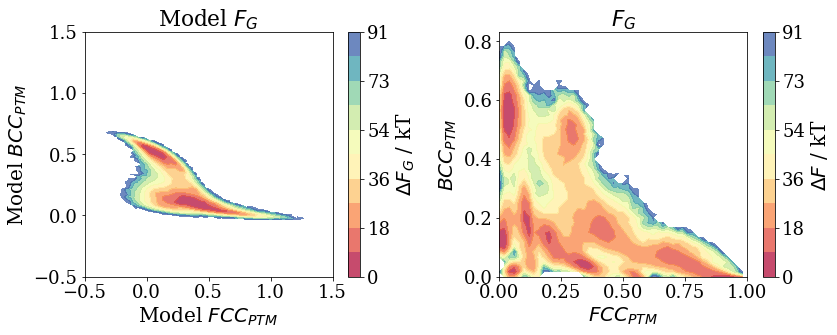

In [36]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

cp = axs[0].contourf(YGCR_1[:-1], XGCR_1[:-1], FGCR_1.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(XreweCR_1[:-1], YreweCR_1[:-1], FreweCR_1, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[1].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(np.min(XreweCR_1),np.max(XreweCR_1))
axs[1].set_ylim(np.min(YreweCR_1),np.max(YreweCR_1))
axs[1].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/CR_1_2DFES.png", dpi=500)

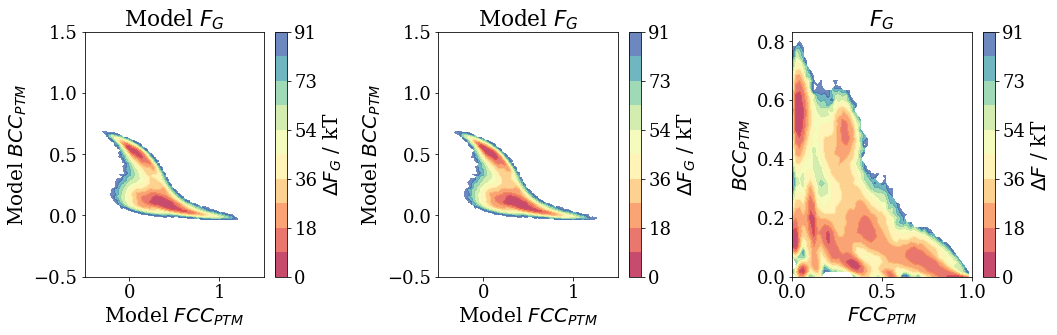

In [37]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

cp = axs[0].contourf(YGCR_1_a[:-1], XGCR_1_a[:-1], FGCR_1_a.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(YGCR_1[:-1], XGCR_1[:-1], FGCR_1.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[1].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_title("Model $F_G$")

cp = axs[2].contourf(XreweCR_1[:-1], YreweCR_1[:-1], FreweCR_1, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[2].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[2].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[2].set_xlim(np.min(XreweCR_1),np.max(XreweCR_1))
axs[2].set_ylim(np.min(YreweCR_1),np.max(YreweCR_1))
axs[2].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/CR_1_2DFES_sanity.png", dpi=500)

## CR 2

In [39]:
path = "Convergence_CR_2/"

n_simulations = 100
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]


for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")   
    
                                     
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        maxx=(np.max(position_x))
        minx=(np.min(position_x))
        maxy=(np.max(position_y))
        miny=(np.min(position_y))    
        #COMPUTE Mean force and weight of the simulation
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.03,0.03], error_pace = int(len(HILLS)/10), 
                            base_terms = master_patch[-1], nhills=-1, min_grid=[minx, miny], max_grid=[maxx, maxy], FES_cutoff = -1, use_weighted_st_dev=False)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
        
    
        # store forces for bootstrap analysis     
        forces_all.append([Ftot_den, Ftot_x, Ftot_y])
        #store results in master_array
        master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
        #patch master and store result in master_patch
        master_patch.append(MFI.patch_2D(master))
        #save ofe history and time
        ofe_history_patch += ofe_history
        time_history_patch += [element+time_history_patch[-1] for element in time_history]


|**************************************************| 100% | Average Mean Force Error: 8.227
|**************************************************| 100% | Average Mean Force Error: 9.525
|**************************************************| 100% | Average Mean Force Error: 8.211
|**************************************************| 100% | Average Mean Force Error: 8.017
|**************************************************| 100% | Average Mean Force Error: 6.495
|**************************************************| 100% | Average Mean Force Error: 6.318
|**************************************************| 100% | Average Mean Force Error: 5.397
|**************************************************| 100% | Average Mean Force Error: 5.244
|**************************************************| 100% | Average Mean Force Error: 5.114
|**************************************************| 100% | Average Mean Force Error: 4.716
|**************************************************| 100% | Average Mean Force 

In [40]:
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration 
[X, Y, FES_CR_2] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=[-0.5,-0.5], max_grid=[1.5, 1.5])

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-0.5, -0.5], [1.5, 1.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]

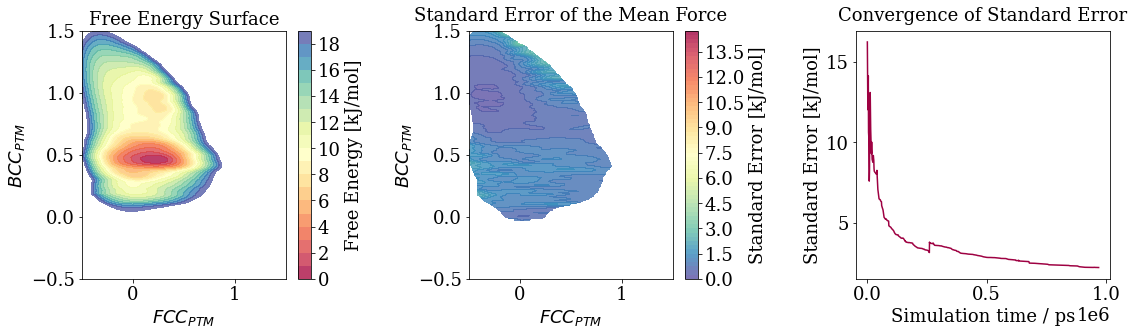

In [41]:
plot_FES =  MFI.zero_to_nan(FES_CR_2*cutoff)
TOTAL_DENSITY = MFI.zero_to_nan(master_patch[-1][0]*cutoff)
CONVMAP = MFI.zero_to_nan(ofe*cutoff)
CONV_history= ofe_history_patch
CONV_history_time = time_history_patch
FES_lim=20
ofe_map_lim=6
use_weighted_st_dev=False
FES_step=1
ofe_map_lim=15
ofe_step=0.25

fig, axs = plt.subplots(1,3, figsize=(16,5))

cp = axs[0].contourf(Y, X, plot_FES.T, levels=range(0, FES_lim, FES_step), cmap='Spectral', antialiased=False, alpha=0.8)
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("Free Energy [kJ/mol]", fontsize=18)
axs[0].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[0].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5,1.5)
axs[0].set_title('Free Energy Surface', fontsize=18)

cp = axs[1].contourf(Y, X, MFI.zero_to_nan(CONVMAP).T, levels=np.arange(0, ofe_map_lim, ofe_step), cmap='Spectral_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("Standard Deviation [kJ/mol]", fontsize=11) if use_weighted_st_dev==True else cbar.set_label("Standard Error [kJ/mol]", fontsize=18)
axs[1].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[1].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5,1.5)
axs[1].set_title('Standard Error of the Mean Force', fontsize=18, pad=10)


axs[2].plot( CONV_history_time, CONV_history, label="global ofe", color=cs["Bordeaux"]);
axs[2].set_ylabel('Standard Error [kJ/mol]', fontsize=18)
axs[2].set_xlabel('Simulation time / ps', fontsize=18)
axs[2].set_title('Convergence of Standard Error', fontsize=18, pad=10)

    
plt.tight_layout()
plt.savefig("Figs_paper/Fs_CR_2_overview.png", dpi=500)

In [42]:
positions_x_CR_2 = np.empty(0)
positions_y_CR_2 = np.empty(0)

analyticals_x_CR_2 = np.empty(0)
analyticals_y_CR_2 = np.empty(0)
analyticals_z_CR_2 = np.empty(0)

weights_CR_2 = np.empty(0)
weights_pure_CR_2 = np.empty(0)

corrs_CR_2 = np.empty(0)

for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")
        # #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        NH0 = len(HILLS)
        #Read bias and analytical variables
        bias = np.loadtxt(sim_path + "colvar.out")[:,3]
        geo_corr = np.loadtxt(sim_path + "grads_corr.dat")
        analytical_xyz = np.loadtxt(sim_path + "PTM_labels.dat")[:,:3]/500
        analytical_x = analytical_xyz[:,1]
        analytical_y = analytical_xyz[:,0]
        analytical_z = analytical_xyz[:,2]
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        
        #Compute c(t) and sample weights_CR_2
        [expC,BIAS2Dfinal]=MFI.coft(HILLS=HILLS,FES=FES_CR_2,kT=kT,total_number_of_hills=NH0,stride=4,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
        c=kT*np.log(expC)
        weightsMETAD=np.exp(bias[:4*NH0-3]/kT-c/kT)*geo_corr[:4*NH0-3]
        weights_p = np.exp(bias[:4*NH0-3]/kT-c/kT)
        positions_x_CR_2 = np.concatenate([positions_x_CR_2,position_x[:4*NH0-3]])
        positions_y_CR_2 = np.concatenate([positions_y_CR_2,position_y[:4*NH0-3]])         
        analyticals_x_CR_2 = np.concatenate([analyticals_x_CR_2,analytical_x[:4*NH0-3]])
        analyticals_y_CR_2 = np.concatenate([analyticals_y_CR_2,analytical_y[:4*NH0-3]])
        analyticals_z_CR_2 = np.concatenate([analyticals_z_CR_2,analytical_z[:4*NH0-3]])

        weights_CR_2 = np.concatenate([weights_CR_2,NH0*weightsMETAD])
        weights_pure_CR_2 = np.concatenate([weights_pure_CR_2,NH0*weights_p])
        corrs_CR_2 = np.concatenate([corrs_CR_2, geo_corr])


|**************************************************| 99% | exp(c(t)/kT): 1.2475270120864588
|**************************************************| 99% | exp(c(t)/kT): 1.0593568776919724
|**************************************************| 99% | exp(c(t)/kT): 1.0320545904988982
|**************************************************| 99% | exp(c(t)/kT): 1.0428966084378677
|**************************************************| 99% | exp(c(t)/kT): 1.3581273967131746
|**************************************************| 99% | exp(c(t)/kT): 1.1020327245945974
|**************************************************| 99% | exp(c(t)/kT): 1.0324889495103375
|**************************************************| 99% | exp(c(t)/kT): 1.0509803703402771
|**************************************************| 99% | exp(c(t)/kT): 1.1638266098438763
|**************************************************| 99% | exp(c(t)/kT): 1.0122924628922137
|**************************************************| 99% | exp(c(t)/kT): 1.0915

In [43]:
np.savetxt("Data_paper/CR_2_positions_x.dat", positions_y_CR_2)
np.savetxt("Data_paper/CR_2_positions_y.dat", positions_y_CR_2)

np.savetxt("Data_paper/CR_2_analyticals_x.dat", analyticals_x_CR_2)
np.savetxt("Data_paper/CR_2_analyticals_y.dat", analyticals_y_CR_2)
np.savetxt("Data_paper/CR_2_analyticals_z.dat", analyticals_z_CR_2)

np.savetxt("Data_paper/CR_2_weights.dat", weights_CR_2)
np.savetxt("Data_paper/CR_2_corrs.dat", corrs_CR_2)

In [44]:
#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PGCR_2_a,XGCR_2_a,YGCR_2_a]=np.histogram2d(positions_x_CR_2, positions_y_CR_2,bins=50,weights=weights_pure_CR_2)
PGCR_2_a = PGCR_2_a.T
FGCR_2_a = -kT*np.log(PGCR_2_a)-np.min(-kT*np.log(PGCR_2_a))

[PGCR_2,XGCR_2,YGCR_2]=np.histogram2d(positions_x_CR_2, positions_y_CR_2,bins=50,weights=weights_CR_2)
PGCR_2 = PGCR_2.T
FGCR_2 = -kT*np.log(PGCR_2)-np.min(-kT*np.log(PGCR_2))

#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PreweCR_2,XreweCR_2,YreweCR_2]=np.histogram2d(analyticals_x_CR_2, analyticals_y_CR_2,bins=50,weights=weights_CR_2)
PreweCR_2 = PreweCR_2.T
FreweCR_2 = -kT*np.log(PreweCR_2)-np.min(-kT*np.log(PreweCR_2))

/tmp/ipykernel_16146/1502391235.py:4: RuntimeWarning: divide by zero encountered in log
  FGCR_2_a = -kT*np.log(PGCR_2_a)-np.min(-kT*np.log(PGCR_2_a))
/tmp/ipykernel_16146/1502391235.py:8: RuntimeWarning: divide by zero encountered in log
  FGCR_2 = -kT*np.log(PGCR_2)-np.min(-kT*np.log(PGCR_2))
/tmp/ipykernel_16146/1502391235.py:13: RuntimeWarning: divide by zero encountered in log
  FreweCR_2 = -kT*np.log(PreweCR_2)-np.min(-kT*np.log(PreweCR_2))


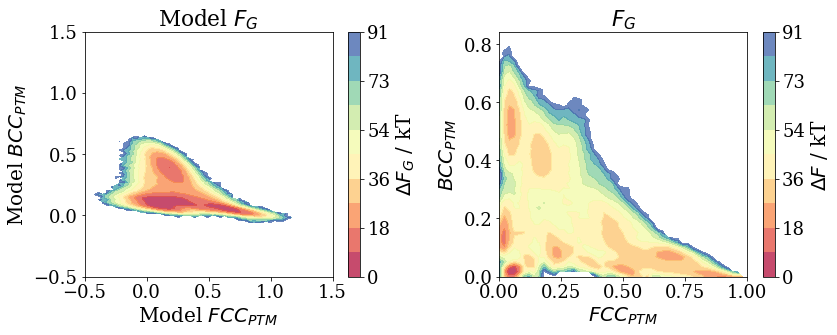

In [45]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

cp = axs[0].contourf(YGCR_2[:-1], XGCR_2[:-1], FGCR_2.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(XreweCR_2[:-1], YreweCR_2[:-1], FreweCR_2, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[1].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(np.min(XreweCR_2),np.max(XreweCR_2))
axs[1].set_ylim(np.min(YreweCR_2),np.max(YreweCR_2))
axs[1].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/CR_2_2DFES.png", dpi=500)

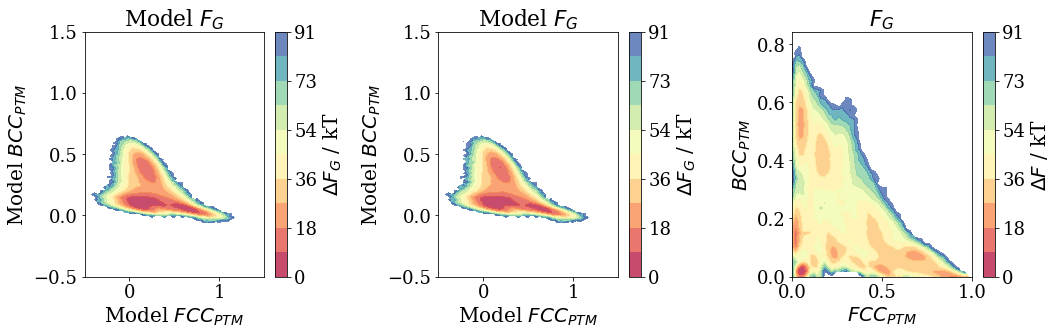

In [46]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

cp = axs[0].contourf(YGCR_2_a[:-1], XGCR_2_a[:-1], FGCR_2_a.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(YGCR_2[:-1], XGCR_2[:-1], FGCR_2.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[1].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_title("Model $F_G$")

cp = axs[2].contourf(XreweCR_2[:-1], YreweCR_2[:-1], FreweCR_2, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[2].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[2].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[2].set_xlim(np.min(XreweCR_2),np.max(XreweCR_2))
axs[2].set_ylim(np.min(YreweCR_2),np.max(YreweCR_2))
axs[2].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/CR_2_2DFES_sanity.png", dpi=500)

## CR 3

In [47]:
path = "Convergence_CR_3/"

n_simulations = 100
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]


for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")   
    
                                     
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        maxx=(np.max(position_x))
        minx=(np.min(position_x))
        maxy=(np.max(position_y))
        miny=(np.min(position_y))    
        #COMPUTE Mean force and weight of the simulation
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.03,0.03], error_pace = int(len(HILLS)/10), 
                            base_terms = master_patch[-1], nhills=-1, min_grid=[minx, miny], max_grid=[maxx, maxy], FES_cutoff = -1, use_weighted_st_dev=False)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
        
    
        # store forces for bootstrap analysis     
        forces_all.append([Ftot_den, Ftot_x, Ftot_y])
        #store results in master_array
        master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
        #patch master and store result in master_patch
        master_patch.append(MFI.patch_2D(master))
        #save ofe history and time
        ofe_history_patch += ofe_history
        time_history_patch += [element+time_history_patch[-1] for element in time_history]


|**************************************************| 100% | Average Mean Force Error: 6.651
|**************************************************| 100% | Average Mean Force Error: 7.181
|**************************************************| 100% | Average Mean Force Error: 6.728
|**************************************************| 100% | Average Mean Force Error: 6.598
|**************************************************| 100% | Average Mean Force Error: 6.562
|**************************************************| 100% | Average Mean Force Error: 4.502
|**************************************************| 100% | Average Mean Force Error: 4.187
|**************************************************| 100% | Average Mean Force Error: 4.158
|**************************************************| 100% | Average Mean Force Error: 4.151
|**************************************************| 100% | Average Mean Force Error: 4.094
|**************************************************| 100% | Average Mean Force 

In [48]:
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration 
[X, Y, FES_CR_3] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=[-0.5,-0.5], max_grid=[1.5, 1.5])

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-0.5, -0.5], [1.5, 1.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]

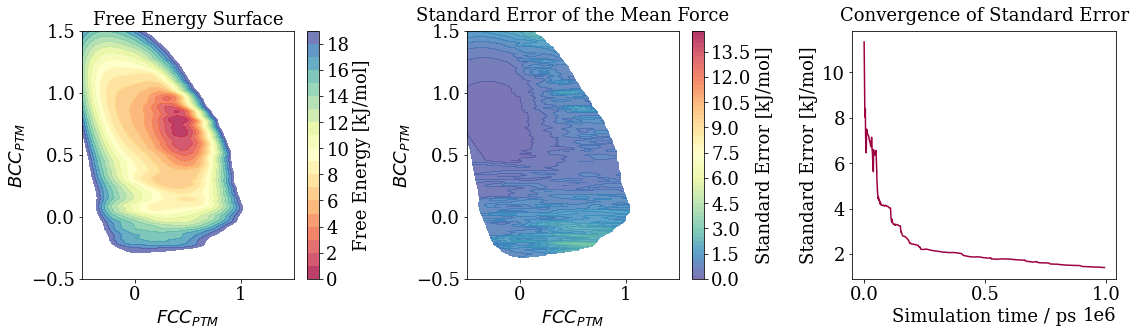

In [49]:
plot_FES =  MFI.zero_to_nan(FES_CR_3*cutoff)
TOTAL_DENSITY = MFI.zero_to_nan(master_patch[-1][0]*cutoff)
CONVMAP = MFI.zero_to_nan(ofe*cutoff)
CONV_history= ofe_history_patch
CONV_history_time = time_history_patch
FES_lim=20
ofe_map_lim=6
use_weighted_st_dev=False
FES_step=1
ofe_map_lim=15
ofe_step=0.25

fig, axs = plt.subplots(1,3, figsize=(16,5))

cp = axs[0].contourf(Y, X, plot_FES.T, levels=range(0, FES_lim, FES_step), cmap='Spectral', antialiased=False, alpha=0.8)
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("Free Energy [kJ/mol]", fontsize=18)
axs[0].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[0].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5,1.5)
axs[0].set_title('Free Energy Surface', fontsize=18)

cp = axs[1].contourf(Y, X, MFI.zero_to_nan(CONVMAP).T, levels=np.arange(0, ofe_map_lim, ofe_step), cmap='Spectral_r', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("Standard Deviation [kJ/mol]", fontsize=11) if use_weighted_st_dev==True else cbar.set_label("Standard Error [kJ/mol]", fontsize=18)
axs[1].set_xlabel('$FCC_{PTM}$', fontsize=18)
axs[1].set_ylabel('$BCC_{PTM}$', fontsize=18)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5,1.5)
axs[1].set_title('Standard Error of the Mean Force', fontsize=18, pad=10)


axs[2].plot( CONV_history_time, CONV_history, label="global ofe", color=cs["Bordeaux"]);
axs[2].set_ylabel('Standard Error [kJ/mol]', fontsize=18)
axs[2].set_xlabel('Simulation time / ps', fontsize=18)
axs[2].set_title('Convergence of Standard Error', fontsize=18, pad=10)

    
plt.tight_layout()
plt.savefig("Figs_paper/Fs_CR_3_overview.png", dpi=500)

In [50]:
positions_x_CR_3 = np.empty(0)
positions_y_CR_3 = np.empty(0)

analyticals_x_CR_3 = np.empty(0)
analyticals_y_CR_3 = np.empty(0)
analyticals_z_CR_3 = np.empty(0)

weights_CR_3 = np.empty(0)
weights_pure_CR_3 = np.empty(0)

corrs_CR_3 = np.empty(0)

for sim in range(1,21):
    for ulation in range(5):
        sim_path = path + str(sim) + "/" + str(ulation) + "/"
        print("\nSimulation: ", sim_path, "   |   " , end="")
        # #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name=sim_path + "HILLS")
        NH0 = len(HILLS)
        #Read bias and analytical variables
        bias = np.loadtxt(sim_path + "colvar.out")[:,3]
        geo_corr = np.loadtxt(sim_path + "grads_corr.dat")
        analytical_xyz = np.loadtxt(sim_path + "PTM_labels.dat")[:,:3]/500
        analytical_x = analytical_xyz[:,1]
        analytical_y = analytical_xyz[:,0]
        analytical_z = analytical_xyz[:,2]
        [position_x, position_y] = MFI.load_position_2D(position_name=sim_path + "colvar.out")
        
        #Compute c(t) and sample weights_CR_3
        [expC,BIAS2Dfinal]=MFI.coft(HILLS=HILLS,FES=FES_CR_3,kT=kT,total_number_of_hills=NH0,stride=4,min_grid=np.array((minx,miny)), max_grid=np.array((maxx,maxy)))
        c=kT*np.log(expC)
        weightsMETAD=np.exp(bias[:4*NH0-3]/kT-c/kT)*geo_corr[:4*NH0-3]
        weights_p = np.exp(bias[:4*NH0-3]/kT-c/kT)
        positions_x_CR_3 = np.concatenate([positions_x_CR_3,position_x[:4*NH0-3]])
        positions_y_CR_3 = np.concatenate([positions_y_CR_3,position_y[:4*NH0-3]])         
        analyticals_x_CR_3 = np.concatenate([analyticals_x_CR_3,analytical_x[:4*NH0-3]])
        analyticals_y_CR_3 = np.concatenate([analyticals_y_CR_3,analytical_y[:4*NH0-3]])
        analyticals_z_CR_3 = np.concatenate([analyticals_z_CR_3,analytical_z[:4*NH0-3]])

        weights_CR_3 = np.concatenate([weights_CR_3,NH0*weightsMETAD])
        weights_pure_CR_3 = np.concatenate([weights_pure_CR_3,NH0*weights_p])
        corrs_CR_3 = np.concatenate([corrs_CR_3, geo_corr])


|**************************************************| 99% | exp(c(t)/kT): 1.1724340886948355
|**************************************************| 99% | exp(c(t)/kT): 1.0478538615675121
|**************************************************| 99% | exp(c(t)/kT): 1.1604144114702752
|**************************************************| 99% | exp(c(t)/kT): 1.0426031275010108
|**************************************************| 99% | exp(c(t)/kT): 1.2265904496496043
|**************************************************| 99% | exp(c(t)/kT): 1.0505925198278345
|**************************************************| 99% | exp(c(t)/kT): 1.0744099167316477
|**************************************************| 99% | exp(c(t)/kT): 1.1029767802582602
|**************************************************| 99% | exp(c(t)/kT): 1.1241569724604755
|**************************************************| 99% | exp(c(t)/kT): 1.0477765436542153
|**************************************************| 99% | exp(c(t)/kT): 1.0906

In [51]:
np.savetxt("Data_paper/CR_3_positions_x.dat", positions_x_CR_3)
np.savetxt("Data_paper/CR_3_positions_y.dat", positions_y_CR_3)

np.savetxt("Data_paper/CR_3_analyticals_x.dat", analyticals_x_CR_3)
np.savetxt("Data_paper/CR_3_analyticals_y.dat", analyticals_y_CR_3)
np.savetxt("Data_paper/CR_3_analyticals_z.dat", analyticals_z_CR_3)

np.savetxt("Data_paper/CR_3_weights.dat", weights_CR_3)
np.savetxt("Data_paper/CR_3_corrs.dat", corrs_CR_3)

In [52]:
#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PGCR_3_a,XGCR_3_a,YGCR_3_a]=np.histogram2d(positions_x_CR_3, positions_y_CR_3,bins=50,weights=weights_pure_CR_3)
PGCR_3_a = PGCR_3_a.T
FGCR_3_a = -kT*np.log(PGCR_3_a)-np.min(-kT*np.log(PGCR_3_a))

[PGCR_3,XGCR_3,YGCR_3]=np.histogram2d(positions_x_CR_3, positions_y_CR_3,bins=50,weights=weights_CR_3)
PGCR_3 = PGCR_3.T
FGCR_3 = -kT*np.log(PGCR_3)-np.min(-kT*np.log(PGCR_3))

#Reweight the probability density in the analytical CV space and compute reweighted F(S)
[PreweCR_3,XreweCR_3,YreweCR_3]=np.histogram2d(analyticals_x_CR_3, analyticals_y_CR_3,bins=50,weights=weights_CR_3)
PreweCR_3 = PreweCR_3.T
FreweCR_3 = -kT*np.log(PreweCR_3)-np.min(-kT*np.log(PreweCR_3))

/tmp/ipykernel_16146/456899257.py:4: RuntimeWarning: divide by zero encountered in log
  FGCR_3_a = -kT*np.log(PGCR_3_a)-np.min(-kT*np.log(PGCR_3_a))
/tmp/ipykernel_16146/456899257.py:8: RuntimeWarning: divide by zero encountered in log
  FGCR_3 = -kT*np.log(PGCR_3)-np.min(-kT*np.log(PGCR_3))
/tmp/ipykernel_16146/456899257.py:13: RuntimeWarning: divide by zero encountered in log
  FreweCR_3 = -kT*np.log(PreweCR_3)-np.min(-kT*np.log(PreweCR_3))


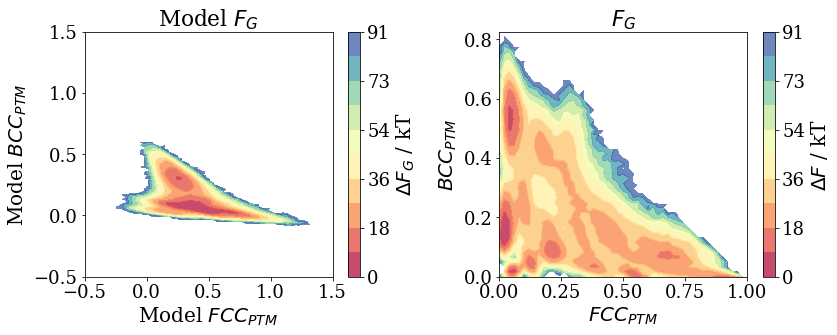

In [53]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

cp = axs[0].contourf(YGCR_3[:-1], XGCR_3[:-1], FGCR_3.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(XreweCR_3[:-1], YreweCR_3[:-1], FreweCR_3, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[1].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(np.min(XreweCR_3),np.max(XreweCR_3))
axs[1].set_ylim(np.min(YreweCR_3),np.max(YreweCR_3))
axs[1].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/CR_3_2DFES.png", dpi=500)

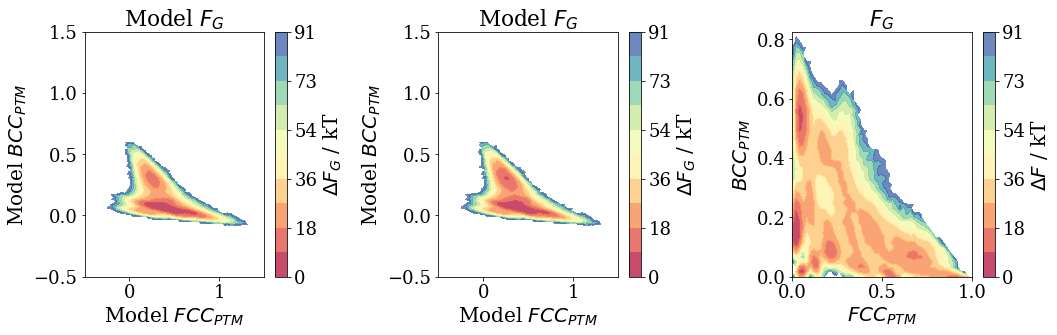

In [54]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

cp = axs[0].contourf(YGCR_3_a[:-1], XGCR_3_a[:-1], FGCR_3_a.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[0].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[0].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-0.5, 1.5)
axs[0].set_title("Model $F_G$")

cp = axs[1].contourf(YGCR_3[:-1], XGCR_3[:-1], FGCR_3.T, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1], format="%d")
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
axs[1].set_ylabel('Model $BCC_{PTM}$',fontsize=20)
axs[1].set_xlabel('Model $FCC_{PTM}$',fontsize=20)
axs[1].set_xlim(-0.5,1.5)
axs[1].set_ylim(-0.5, 1.5)
axs[1].set_title("Model $F_G$")

cp = axs[2].contourf(XreweCR_3[:-1], YreweCR_3[:-1], FreweCR_3, cmap='Spectral',levels=np.arange(0, 100, kT), antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2], format="%d")
cbar.set_label("$\Delta F$ / kT",fontsize=20)
axs[2].set_ylabel('$BCC_{PTM}$',fontsize=20)
axs[2].set_xlabel('$FCC_{PTM}$',fontsize=20)
axs[2].set_xlim(np.min(XreweCR_3),np.max(XreweCR_3))
axs[2].set_ylim(np.min(YreweCR_3),np.max(YreweCR_3))
axs[2].set_title("$F_G$")
plt.tight_layout()
plt.savefig("Figs_paper/CR_3_2DFES_sanity.png", dpi=500)

# 3D

In [55]:
# L2_1
X_r, Y_r, Z_r = np.mgrid[analyticals_x_L2_1.min():analyticals_x_L2_1.max():50j, analyticals_y_L2_1.min():analyticals_y_L2_1.max():50j, analyticals_z_L2_1.min():analyticals_z_L2_1.max():50j]
positions = np.vstack([X_r.ravel(), Y_r.ravel(), Z_r.ravel()])
values = np.vstack([analyticals_x_L2_1, analyticals_y_L2_1, analyticals_z_L2_1])
kde = sts.gaussian_kde(values, weights=weights_L2_1)
Z = np.reshape(kde(positions).T, X_r.shape)

F3DL2_1 = -kT*np.log(Z)-np.min(-kT*np.log(Z))
np.save("Data_paper/L2_1_3D_FES", F3DL2_1)

/tmp/ipykernel_16146/1288286765.py:8: RuntimeWarning: divide by zero encountered in log
  F3DL2_1 = -kT*np.log(Z)-np.min(-kT*np.log(Z))


In [56]:
# L2_2
X_r, Y_r, Z_r = np.mgrid[analyticals_x_L2_2.min():analyticals_x_L2_2.max():50j, analyticals_y_L2_2.min():analyticals_y_L2_2.max():50j, analyticals_z_L2_2.min():analyticals_z_L2_2.max():50j]
positions = np.vstack([X_r.ravel(), Y_r.ravel(), Z_r.ravel()])
values = np.vstack([analyticals_x_L2_2, analyticals_y_L2_2, analyticals_z_L2_2])
kde = sts.gaussian_kde(values, weights=weights_L2_2)
Z = np.reshape(kde(positions).T, X_r.shape)

F3DL2_2 = -kT*np.log(Z)-np.min(-kT*np.log(Z))
np.save("Data_paper/L2_2_3D_FES", F3DL2_2)

/tmp/ipykernel_16146/3712583924.py:8: RuntimeWarning: divide by zero encountered in log
  F3DL2_2 = -kT*np.log(Z)-np.min(-kT*np.log(Z))


In [57]:
# L2_3
X_r, Y_r, Z_r = np.mgrid[analyticals_x_L2_3.min():analyticals_x_L2_3.max():50j, analyticals_y_L2_3.min():analyticals_y_L2_3.max():50j, analyticals_z_L2_3.min():analyticals_z_L2_3.max():50j]
positions = np.vstack([X_r.ravel(), Y_r.ravel(), Z_r.ravel()])
values = np.vstack([analyticals_x_L2_3, analyticals_y_L2_3, analyticals_z_L2_3])
kde = sts.gaussian_kde(values, weights=weights_L2_3)
Z = np.reshape(kde(positions).T, X_r.shape)

F3DL2_3 = -kT*np.log(Z)-np.min(-kT*np.log(Z))
np.save("Data_paper/L2_3_3D_FES", F3DL2_3)

/tmp/ipykernel_16146/2507792097.py:8: RuntimeWarning: divide by zero encountered in log
  F3DL2_3 = -kT*np.log(Z)-np.min(-kT*np.log(Z))


In [58]:
# CR_1
X_r, Y_r, Z_r = np.mgrid[analyticals_x_CR_1.min():analyticals_x_CR_1.max():50j, analyticals_y_CR_1.min():analyticals_y_CR_1.max():50j, analyticals_z_CR_1.min():analyticals_z_CR_1.max():50j]
positions = np.vstack([X_r.ravel(), Y_r.ravel(), Z_r.ravel()])
values = np.vstack([analyticals_x_CR_1, analyticals_y_CR_1, analyticals_z_CR_1])
kde = sts.gaussian_kde(values, weights=weights_CR_1)
Z = np.reshape(kde(positions).T, X_r.shape)

F3DCR_1 = -kT*np.log(Z)-np.min(-kT*np.log(Z))
np.save("Data_paper/CR_1_3D_FES", F3DCR_1)

/tmp/ipykernel_16146/1392929786.py:8: RuntimeWarning: divide by zero encountered in log
  F3DCR_1 = -kT*np.log(Z)-np.min(-kT*np.log(Z))


In [59]:
# CR_2
X_r, Y_r, Z_r = np.mgrid[analyticals_x_CR_2.min():analyticals_x_CR_2.max():50j, analyticals_y_CR_2.min():analyticals_y_CR_2.max():50j, analyticals_z_CR_2.min():analyticals_z_CR_2.max():50j]
positions = np.vstack([X_r.ravel(), Y_r.ravel(), Z_r.ravel()])
values = np.vstack([analyticals_x_CR_2, analyticals_y_CR_2, analyticals_z_CR_2])
kde = sts.gaussian_kde(values, weights=weights_CR_2)
Z = np.reshape(kde(positions).T, X_r.shape)

F3DCR_2 = -kT*np.log(Z)-np.min(-kT*np.log(Z))
np.save("Data_paper/CR_2_3D_FES", F3DCR_2)

/tmp/ipykernel_16146/4002587520.py:8: RuntimeWarning: divide by zero encountered in log
  F3DCR_2 = -kT*np.log(Z)-np.min(-kT*np.log(Z))


In [60]:
# CR_3
X_r, Y_r, Z_r = np.mgrid[analyticals_x_CR_3.min():analyticals_x_CR_3.max():50j, analyticals_y_CR_3.min():analyticals_y_CR_3.max():50j, analyticals_z_CR_3.min():analyticals_z_CR_3.max():50j]
positions = np.vstack([X_r.ravel(), Y_r.ravel(), Z_r.ravel()])
values = np.vstack([analyticals_x_CR_3, analyticals_y_CR_3, analyticals_z_CR_3])
kde = sts.gaussian_kde(values, weights=weights_CR_3)
Z = np.reshape(kde(positions).T, X_r.shape)

F3DCR_3 = -kT*np.log(Z)-np.min(-kT*np.log(Z))
np.save("Data_paper/CR_3_3D_FES", F3DCR_3)

/tmp/ipykernel_16146/4080369511.py:8: RuntimeWarning: divide by zero encountered in log
  F3DCR_3 = -kT*np.log(Z)-np.min(-kT*np.log(Z))


# Path Plots

In [2]:
F3DL2_1 = np.load("Data_paper/L2_1_3D_FES.npy")
F3DL2_2 = np.load("Data_paper/L2_2_3D_FES.npy")
F3DL2_3 = np.load("Data_paper/L2_3_3D_FES.npy")
F3DCR_1 = np.load("Data_paper/CR_1_3D_FES.npy")
F3DCR_2 = np.load("Data_paper/CR_2_3D_FES.npy")
F3DCR_3 = np.load("Data_paper/CR_3_3D_FES.npy")

In [3]:
positions_x_cr_1 = np.loadtxt("Data_paper/CR_1_positions_x.dat")
positions_y_cr_1 = np.loadtxt("Data_paper/CR_1_positions_y.dat")

analytical_x_cr_1 = np.loadtxt("Data_paper/CR_1_analyticals_x.dat")
analytical_y_cr_1 = np.loadtxt("Data_paper/CR_1_analyticals_y.dat")
analytical_z_cr_1 = np.loadtxt("Data_paper/CR_1_analyticals_z.dat")

weights_cr_1 = np.loadtxt("Data_paper/CR_1_weights.dat")

In [4]:
positions_x_cr_2 = np.loadtxt("Data_paper/CR_2_positions_x.dat")
positions_y_cr_2 = np.loadtxt("Data_paper/CR_2_positions_y.dat")

analytical_x_cr_2 = np.loadtxt("Data_paper/CR_2_analyticals_x.dat")
analytical_y_cr_2 = np.loadtxt("Data_paper/CR_2_analyticals_y.dat")
analytical_z_cr_2 = np.loadtxt("Data_paper/CR_2_analyticals_z.dat")

weights_cr_2 = np.loadtxt("Data_paper/CR_2_weights.dat")

In [5]:
positions_x_cr_3 = np.loadtxt("Data_paper/CR_3_positions_x.dat")
positions_y_cr_3 = np.loadtxt("Data_paper/CR_3_positions_y.dat")

analytical_x_cr_3 = np.loadtxt("Data_paper/CR_3_analyticals_x.dat")
analytical_y_cr_3 = np.loadtxt("Data_paper/CR_3_analyticals_y.dat")
analytical_z_cr_3 = np.loadtxt("Data_paper/CR_3_analyticals_z.dat")

weights_cr_3 = np.loadtxt("Data_paper/CR_3_weights.dat")

In [6]:
positions_x_L2_1 = np.loadtxt("Data_paper/L2_1_positions_x.dat")
positions_y_L2_1 = np.loadtxt("Data_paper/L2_1_positions_y.dat")

analytical_x_L2_1 = np.loadtxt("Data_paper/L2_1_analyticals_x.dat")
analytical_y_L2_1 = np.loadtxt("Data_paper/L2_1_analyticals_y.dat")
analytical_z_L2_1 = np.loadtxt("Data_paper/L2_1_analyticals_z.dat")

weights_L2_1 = np.loadtxt("Data_paper/L2_1_weights.dat")

In [7]:
positions_x_L2_2 = np.loadtxt("Data_paper/L2_2_positions_x.dat")
positions_y_L2_2 = np.loadtxt("Data_paper/L2_2_positions_y.dat")

analytical_x_L2_2 = np.loadtxt("Data_paper/L2_2_analyticals_x.dat")
analytical_y_L2_2 = np.loadtxt("Data_paper/L2_2_analyticals_y.dat")
analytical_z_L2_2 = np.loadtxt("Data_paper/L2_2_analyticals_z.dat")

weights_L2_2 = np.loadtxt("Data_paper/L2_2_weights.dat")

In [8]:
positions_x_L2_3 = np.loadtxt("Data_paper/L2_3_positions_x.dat")
positions_y_L2_3 = np.loadtxt("Data_paper/L2_3_positions_y.dat")

analytical_x_L2_3 = np.loadtxt("Data_paper/L2_3_analyticals_x.dat")
analytical_y_L2_3 = np.loadtxt("Data_paper/L2_3_analyticals_y.dat")
analytical_z_L2_3 = np.loadtxt("Data_paper/L2_3_analyticals_z.dat")

weights_L2_3 = np.loadtxt("Data_paper/L2_3_weights.dat")

In [9]:
X_cr_1, Y_cr_1, Z_cr_1 = np.mgrid[analytical_x_cr_1.min():analytical_x_cr_1.max():50j, analytical_y_cr_1.min():analytical_y_cr_1.max():50j, analytical_z_cr_1.min():analytical_z_cr_1.max():50j]
X_cr_2, Y_cr_2, Z_cr_2 = np.mgrid[analytical_x_cr_2.min():analytical_x_cr_2.max():50j, analytical_y_cr_2.min():analytical_y_cr_2.max():50j, analytical_z_cr_2.min():analytical_z_cr_2.max():50j]
X_cr_3, Y_cr_3, Z_cr_3 = np.mgrid[analytical_x_cr_3.min():analytical_x_cr_3.max():50j, analytical_y_cr_3.min():analytical_y_cr_3.max():50j, analytical_z_cr_3.min():analytical_z_cr_3.max():50j]

X_L2_1, Y_L2_1, Z_L2_1 = np.mgrid[analytical_x_L2_1.min():analytical_x_L2_1.max():50j, analytical_y_L2_1.min():analytical_y_L2_1.max():50j, analytical_z_L2_1.min():analytical_z_L2_1.max():50j]
X_L2_2, Y_L2_2, Z_L2_2 = np.mgrid[analytical_x_L2_2.min():analytical_x_L2_2.max():50j, analytical_y_L2_2.min():analytical_y_L2_2.max():50j, analytical_z_L2_2.min():analytical_z_L2_2.max():50j]
X_L2_3, Y_L2_3, Z_L2_3 = np.mgrid[analytical_x_L2_3.min():analytical_x_L2_3.max():50j, analytical_y_L2_3.min():analytical_y_L2_3.max():50j, analytical_z_L2_3.min():analytical_z_L2_3.max():50j]

In [10]:
def Score_FES(FES, start):
    """Path finding algorithm inspired by Dijkstra's algorithm. This function prepares a copy of the FES grid where each point is scored based on its "Free Energy Distance" to the global minimum.
    Performing a greedy search on the returned grid yields the Minimum Free Energy Path from any point to the global minimum.

    :param FES: Grid representing the 3D FES
    :type FES: nd.array
    :return: Grid containing the scored FES
    :rtype: nd.array
    """

    # Define all the directions in which to look for neighbours
    directions = []
    for m in range(-1, 2):
        for n in range(-1, 2):
            for k in range(-1, 2):
                directions.append(np.array([m, n, k]))

    directions.pop(13)
    directions = np.array(directions)

    # Point with the minimal FE
    #start = np.argwhere(FES == np.min(FES))[0]
    #start = np.array([49,0,0])
    # New grid where -inf represents unvisited nodes
    F_update = np.ones(np.shape(FES))*-np.inf
    # Set the starting point to 0
    F_update[tuple(start)] = 0

    num_bins = np.shape(FES)[0]
    # Find the first neighbourshell
    neighbours = directions + start

    # Filter out any neighbours that leave the grid
    neighbours = neighbours[np.all(neighbours >= 0, axis=1)]
    neighbours = neighbours[np.all(neighbours < num_bins, axis=1)]

    # Set the weights of all first shell neighbours to their real values
    for n in neighbours:
        F_update[tuple(n)] = FES[tuple(n)]
    
    # Start pulsing through the graph until every node has been updated
    while -np.inf in F_update:
        # list of neighbours of the current shell
        next_shell = {}
        # For each node in the neighbourlist

        for i in range(len(neighbours)):
            # find its neighbours
            n_neigh = directions + neighbours[i]
            # Eliminate all that leave the grid
            n_neigh = n_neigh[np.all(n_neigh >= 0, axis=1)]
            n_neigh = n_neigh[np.all(n_neigh < num_bins, axis=1)]
        
           # Eliminate all that have been visited
            mask = []
            for j in range(len(n_neigh)):
                if F_update[tuple(n_neigh[j])] == -np.inf:
                    mask.append(j)
            n_neigh = n_neigh[mask]

            for j in range(len(n_neigh)):
                neigh_ind = tuple(n_neigh[j])
                origin_ind = tuple(neighbours[i])
                # Check if the neighbour is known
                if neigh_ind in next_shell:
                    # Set the dictionary entry to the lower of the two scores
                    # Score is the value of the next_shell member in the real grid
                    # Plus the value of the origin node in the score grid
                    next_shell[neigh_ind] = min(next_shell[neigh_ind], FES[neigh_ind] + F_update[origin_ind])
                else:
                    next_shell[neigh_ind] = FES[neigh_ind] + F_update[origin_ind]
                
        # The new shell now has its lowest possible score assigned through the dictionary
        # Enter the Scores into the score grid
        # And make the new shell the new list of neighbours

        neighbours = []
    
        for n in next_shell:
            F_update[n] = next_shell[n]
            neighbours.append(np.array(n))
        
        neighbours = np.array(neighbours)


        # Print progress
        print("Grid is scored %f %%\r" % (len(np.where(F_update != -np.inf)[1]) / len(F_update.ravel())* 100), end="")

    return F_update

def greedy_path_finding(F_scored, start):
    """A greedy path finding algorithm that returns the path from the start to the global minimum of the given FES via the lowest scored immediate neighbour.

    :param F_scored: Grid representing a FES (should be scored)
    :type F_scored: nd.array
    :param start: index of the starting point
    :type start: Tuple
    :return: List of tuples representing the found path.
    :rtype: List
    """
    # Define all the directions in which to look for neighbours
    directions = []
    for m in range(-1, 2):
        for n in range(-1, 2):
            for k in range(-1, 2):
                directions.append(np.array([m, n, k]))

    i = start[0]
    j = start[1]
    k = start[2]
    path = [(i, j, k)]

    while F_scored[i][j][k] != np.min(F_scored):
        tup = np.array([i, j, k])
        neighbours = directions + tup
        neighbours = neighbours[np.all(neighbours >= 0, axis=1)]
        Fmin = np.inf
        tup_min = tup
        Fcurr = F_scored[tuple(tup)]
        for n in neighbours:
            F = F_scored[tuple(n)]
            if F == Fcurr:
                continue
            if (F < Fmin) and (not tuple(n) in path):
            
                Fmin = F
                tup_min = n
    
        path.append(tuple(tup_min))
        i = tup_min[0]
        j = tup_min[1]
        k = tup_min[2]

    return path 

In [11]:
F3DL2_1_scored_min = Score_FES(F3DL2_1, np.argwhere(F3DL2_1 == np.min(F3DL2_1))[0])
F3DL2_1_scored_fcc = Score_FES(F3DL2_1, np.array([49,0,0]))

F3DL2_2_scored_min = Score_FES(F3DL2_2, np.argwhere(F3DL2_2 == np.min(F3DL2_2))[0])
F3DL2_2_scored_fcc = Score_FES(F3DL2_2, np.array([49,0,0]))

F3DL2_3_scored_min = Score_FES(F3DL2_3, np.argwhere(F3DL2_3 == np.min(F3DL2_3))[0])
F3DL2_3_scored_fcc = Score_FES(F3DL2_3, np.array([49,0,0]))

F3DCR_1_scored_min = Score_FES(F3DCR_1, np.argwhere(F3DCR_1 == np.min(F3DCR_1))[0])
F3DCR_1_scored_fcc = Score_FES(F3DCR_1, np.array([49,0,0]))

F3DCR_2_scored_min = Score_FES(F3DCR_2, np.argwhere(F3DCR_2 == np.min(F3DCR_2))[0])
F3DCR_2_scored_fcc = Score_FES(F3DCR_2, np.array([49,0,0]))

F3DCR_3_scored_min = Score_FES(F3DCR_3, np.argwhere(F3DCR_3 == np.min(F3DCR_3))[0])
F3DCR_3_scored_fcc = Score_FES(F3DCR_3, np.array([49,0,0]))

In [12]:
mep_l2_1_min = greedy_path_finding(F3DL2_1_scored_min, (0, 0, 0))
mep_l2_1_fcc = greedy_path_finding(F3DL2_1_scored_fcc, (0, 0, 0))

mep_cr_1_min = greedy_path_finding(F3DCR_1_scored_min, (0, 0, 0))
mep_cr_1_fcc = greedy_path_finding(F3DCR_1_scored_fcc, (0, 0, 0))

mep_l2_2_min = greedy_path_finding(F3DL2_2_scored_min, (0, 0, 0))
mep_l2_2_fcc = greedy_path_finding(F3DL2_2_scored_fcc, (0, 0, 0))

mep_cr_2_min = greedy_path_finding(F3DCR_2_scored_min, (0, 0, 0))
mep_cr_2_fcc = greedy_path_finding(F3DCR_2_scored_fcc, (0, 0, 0))

mep_l2_3_min = greedy_path_finding(F3DL2_3_scored_min, (0, 0, 0))
mep_l2_3_fcc = greedy_path_finding(F3DL2_3_scored_fcc, (0, 0, 0))

mep_cr_3_min = greedy_path_finding(F3DCR_3_scored_min, (0, 0, 0))
mep_cr_3_fcc = greedy_path_finding(F3DCR_3_scored_fcc, (0, 0, 0))

In [13]:
mep_coords_l2_1_min = []
for i in range(len(mep_l2_1_min)):
    x = X_L2_1[mep_l2_1_min[i]]
    y = Y_L2_1[mep_l2_1_min[i]]
    z = Z_L2_1[mep_l2_1_min[i]]
    mep_coords_l2_1_min.append(np.array([x,y,z]))
mep_coords_l2_1_min = np.array(mep_coords_l2_1_min)


mep_coords_l2_1_fcc = []
for i in range(len(mep_l2_1_fcc)):
    x = X_L2_1[mep_l2_1_fcc[i]]
    y = Y_L2_1[mep_l2_1_fcc[i]]
    z = Z_L2_1[mep_l2_1_fcc[i]]
    mep_coords_l2_1_fcc.append(np.array([x,y,z]))
mep_coords_l2_1_fcc = np.array(mep_coords_l2_1_fcc)

In [14]:
mep_coords_l2_2_min = []
for i in range(len(mep_l2_2_min)):
    x = X_L2_2[mep_l2_2_min[i]]
    y = Y_L2_2[mep_l2_2_min[i]]
    z = Z_L2_2[mep_l2_2_min[i]]
    mep_coords_l2_2_min.append(np.array([x,y,z]))
mep_coords_l2_2_min = np.array(mep_coords_l2_2_min)


mep_coords_l2_2_fcc = []
for i in range(len(mep_l2_2_fcc)):
    x = X_L2_2[mep_l2_2_fcc[i]]
    y = Y_L2_2[mep_l2_2_fcc[i]]
    z = Z_L2_2[mep_l2_2_fcc[i]]
    mep_coords_l2_2_fcc.append(np.array([x,y,z]))
mep_coords_l2_2_fcc = np.array(mep_coords_l2_2_fcc)

In [15]:
mep_coords_l2_3_min = []
for i in range(len(mep_l2_3_min)):
    x = X_L2_3[mep_l2_3_min[i]]
    y = Y_L2_3[mep_l2_3_min[i]]
    z = Z_L2_3[mep_l2_3_min[i]]
    mep_coords_l2_3_min.append(np.array([x,y,z]))
mep_coords_l2_3_min = np.array(mep_coords_l2_3_min)


mep_coords_l2_3_fcc = []
for i in range(len(mep_l2_3_fcc)):
    x = X_L2_3[mep_l2_3_fcc[i]]
    y = Y_L2_3[mep_l2_3_fcc[i]]
    z = Z_L2_3[mep_l2_3_fcc[i]]
    mep_coords_l2_3_fcc.append(np.array([x,y,z]))
mep_coords_l2_3_fcc = np.array(mep_coords_l2_3_fcc)

In [16]:
mep_coords_cr_1_min = []
for i in range(len(mep_cr_1_min)):
    x = X_cr_1[mep_cr_1_min[i]]
    y = Y_cr_1[mep_cr_1_min[i]]
    z = Z_cr_1[mep_cr_1_min[i]]
    mep_coords_cr_1_min.append(np.array([x,y,z]))
mep_coords_cr_1_min = np.array(mep_coords_cr_1_min)


mep_coords_cr_1_fcc = []
for i in range(len(mep_cr_1_fcc)):
    x = X_cr_1[mep_cr_1_fcc[i]]
    y = Y_cr_1[mep_cr_1_fcc[i]]
    z = Z_cr_1[mep_cr_1_fcc[i]]
    mep_coords_cr_1_fcc.append(np.array([x,y,z]))
mep_coords_cr_1_fcc = np.array(mep_coords_cr_1_fcc)

In [17]:
mep_coords_cr_2_min = []
for i in range(len(mep_cr_2_min)):
    x = X_cr_2[mep_cr_2_min[i]]
    y = Y_cr_2[mep_cr_2_min[i]]
    z = Z_cr_2[mep_cr_2_min[i]]
    mep_coords_cr_2_min.append(np.array([x,y,z]))
mep_coords_cr_2_min = np.array(mep_coords_cr_2_min)


mep_coords_cr_2_fcc = []
for i in range(len(mep_cr_2_fcc)):
    x = X_cr_2[mep_cr_2_fcc[i]]
    y = Y_cr_2[mep_cr_2_fcc[i]]
    z = Z_cr_2[mep_cr_2_fcc[i]]
    mep_coords_cr_2_fcc.append(np.array([x,y,z]))
mep_coords_cr_2_fcc = np.array(mep_coords_cr_2_fcc)

In [18]:
mep_coords_cr_3_min = []
for i in range(len(mep_cr_3_min)):
    x = X_cr_3[mep_cr_3_min[i]]
    y = Y_cr_3[mep_cr_3_min[i]]
    z = Z_cr_3[mep_cr_3_min[i]]
    mep_coords_cr_3_min.append(np.array([x,y,z]))
mep_coords_cr_3_min = np.array(mep_coords_cr_3_min)


mep_coords_cr_3_fcc = []
for i in range(len(mep_cr_3_fcc)):
    x = X_cr_3[mep_cr_3_fcc[i]]
    y = Y_cr_3[mep_cr_3_fcc[i]]
    z = Z_cr_3[mep_cr_3_fcc[i]]
    mep_coords_cr_3_fcc.append(np.array([x,y,z]))
mep_coords_cr_3_fcc = np.array(mep_coords_cr_3_fcc)

/tmp/ipykernel_9149/861405875.py:21: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_l2_1_fcc[:,0], mep_coords_l2_1_fcc[:,1], mep_coords_l2_1_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
/tmp/ipykernel_9149/861405875.py:22: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_l2_1_min[:,0], mep_coords_l2_1_min[:,1], mep_coords_l2_1_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")
/tmp/ipykernel_9149/861405875.py:50: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor. 

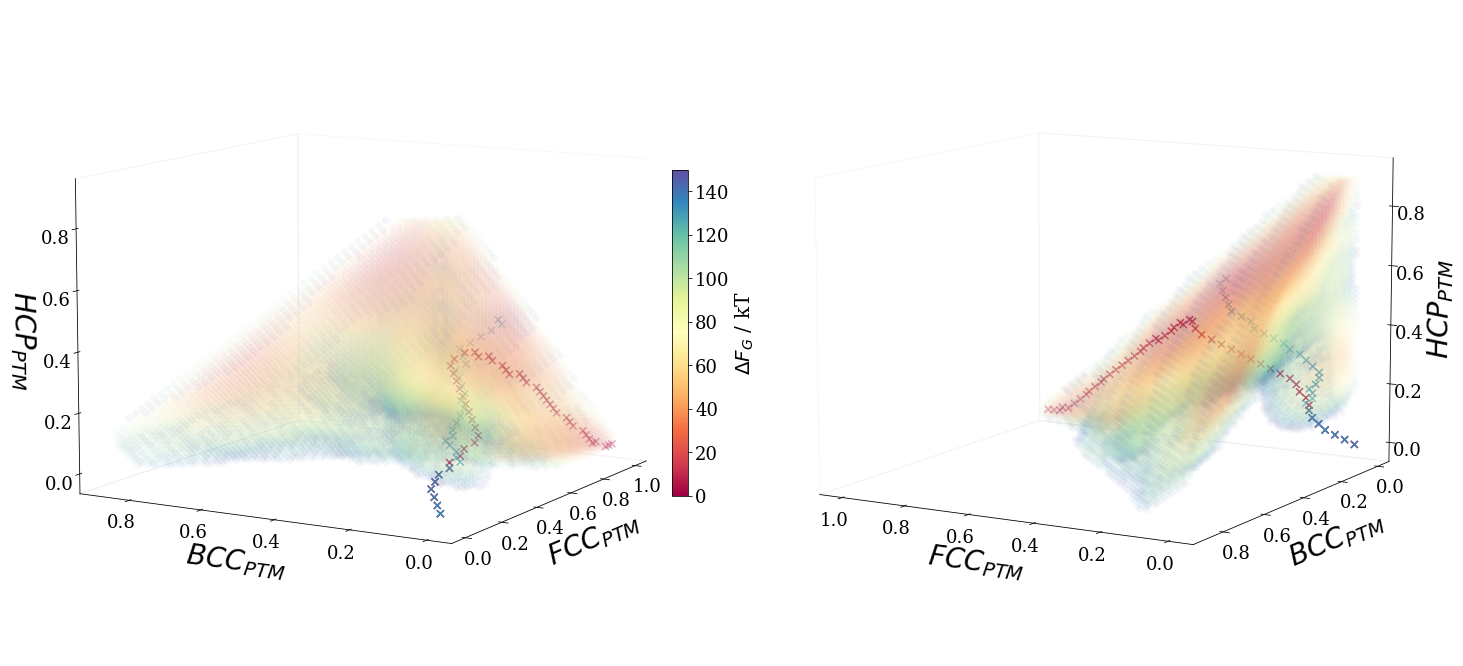

In [30]:
fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(1,2,1, projection="3d")
sub2 = fig.add_subplot(1,2,2, projection="3d")
sub1.xaxis.pane.fill = False
sub1.yaxis.pane.fill = False
sub1.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DL2_1 < 150

# Adjust scale and alpha accordingly
cp = sub1.scatter(X_L2_1, Y_L2_1, Z_L2_1, c=F3DL2_1.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=sub1, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub1.scatter(mep_coords_l2_1_fcc[:,0], mep_coords_l2_1_fcc[:,1], mep_coords_l2_1_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub1.scatter(mep_coords_l2_1_min[:,0], mep_coords_l2_1_min[:,1], mep_coords_l2_1_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub1.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub1.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub1.view_init(10, 210)
#sub1.legend()

sub2.xaxis.pane.fill = False
sub2.yaxis.pane.fill = False
sub2.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DL2_1 < 150

# Adjust scale and alpha accordingly
cp = sub2.scatter(X_L2_1, Y_L2_1, Z_L2_1, c=F3DL2_1.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
#cbar = plt.colorbar(cp, ax=sub2, fraction=0.025, pad=0.07)
#cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub2.scatter(mep_coords_l2_1_fcc[:,0], mep_coords_l2_1_fcc[:,1], mep_coords_l2_1_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub2.scatter(mep_coords_l2_1_min[:,0], mep_coords_l2_1_min[:,1], mep_coords_l2_1_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub2.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub2.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub2.view_init(10, 120)
#sub2.legend()
plt.savefig("Figs_paper/3Ds_L2_1.png", dpi=500)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9149/890243871.py:21: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_l2_2_fcc[:,0], mep_coords_l2_2_fcc[:,1], mep_coords_l2_2_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
/tmp/ipykernel_9149/890243871.py:22: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_l2_2_min[:,0], mep_coords_l2_2_min[:,1], mep_coords_l2_2_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")
/tmp/ipykernel_9149/890243871.py:50: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor. 

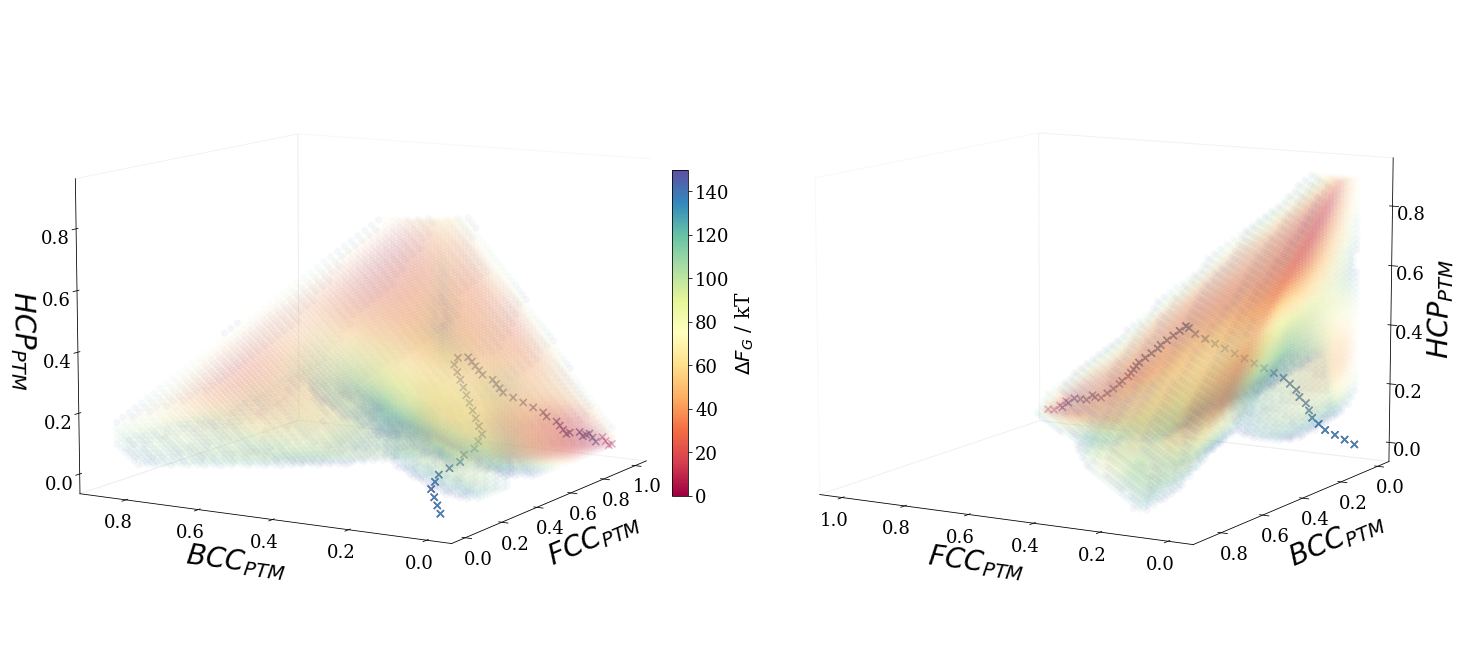

In [31]:
fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(1,2,1, projection="3d")
sub2 = fig.add_subplot(1,2,2, projection="3d")
sub1.xaxis.pane.fill = False
sub1.yaxis.pane.fill = False
sub1.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DL2_2 < 150

# Adjust scale and alpha accordingly
cp = sub1.scatter(X_L2_2, Y_L2_2, Z_L2_2, c=F3DL2_2.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=sub1, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub1.scatter(mep_coords_l2_2_fcc[:,0], mep_coords_l2_2_fcc[:,1], mep_coords_l2_2_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub1.scatter(mep_coords_l2_2_min[:,0], mep_coords_l2_2_min[:,1], mep_coords_l2_2_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub1.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub1.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub1.view_init(10, 210)
#sub1.legend()

sub2.xaxis.pane.fill = False
sub2.yaxis.pane.fill = False
sub2.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DL2_2 < 150

# Adjust scale and alpha accordingly
cp = sub2.scatter(X_L2_2, Y_L2_2, Z_L2_2, c=F3DL2_2.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
#cbar = plt.colorbar(cp, ax=sub2, fraction=0.025, pad=0.07)
#cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub2.scatter(mep_coords_l2_2_fcc[:,0], mep_coords_l2_2_fcc[:,1], mep_coords_l2_2_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub2.scatter(mep_coords_l2_2_min[:,0], mep_coords_l2_2_min[:,1], mep_coords_l2_2_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub2.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub2.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub2.view_init(10, 120)
#sub2.legend()
plt.savefig("Figs_paper/3Ds_L2_2.png", dpi=500)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9149/3797485673.py:21: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_l2_3_fcc[:,0], mep_coords_l2_3_fcc[:,1], mep_coords_l2_3_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
/tmp/ipykernel_9149/3797485673.py:22: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_l2_3_min[:,0], mep_coords_l2_3_min[:,1], mep_coords_l2_3_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")
/tmp/ipykernel_9149/3797485673.py:50: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolo

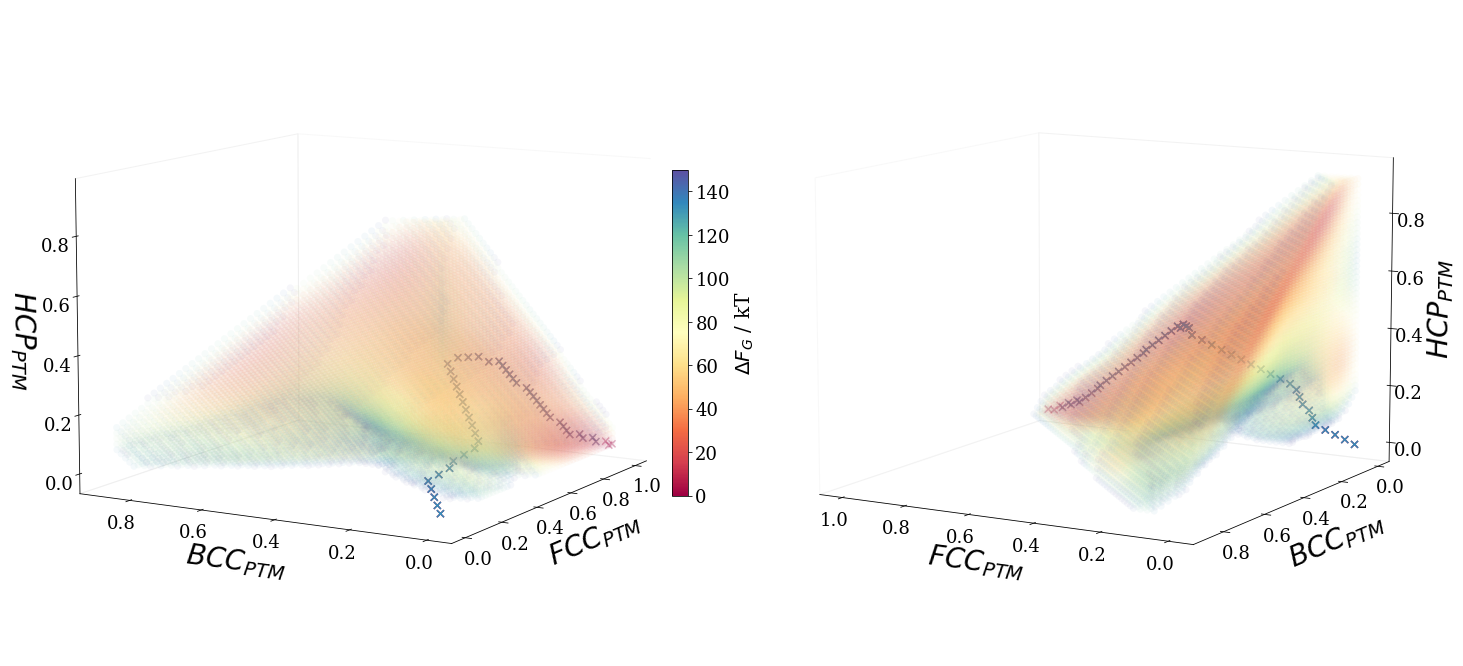

In [32]:
fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(1,2,1, projection="3d")
sub2 = fig.add_subplot(1,2,2, projection="3d")
sub1.xaxis.pane.fill = False
sub1.yaxis.pane.fill = False
sub1.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DL2_3 < 150

# Adjust scale and alpha accordingly
cp = sub1.scatter(X_L2_3, Y_L2_3, Z_L2_3, c=F3DL2_3.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=sub1, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub1.scatter(mep_coords_l2_3_fcc[:,0], mep_coords_l2_3_fcc[:,1], mep_coords_l2_3_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub1.scatter(mep_coords_l2_3_min[:,0], mep_coords_l2_3_min[:,1], mep_coords_l2_3_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub1.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub1.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub1.view_init(10, 210)
#sub1.legend()

sub2.xaxis.pane.fill = False
sub2.yaxis.pane.fill = False
sub2.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DL2_3 < 150

# Adjust scale and alpha accordingly
cp = sub2.scatter(X_L2_3, Y_L2_3, Z_L2_3, c=F3DL2_3.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
#cbar = plt.colorbar(cp, ax=sub2, fraction=0.025, pad=0.07)
#cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub2.scatter(mep_coords_l2_3_fcc[:,0], mep_coords_l2_3_fcc[:,1], mep_coords_l2_3_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub2.scatter(mep_coords_l2_3_min[:,0], mep_coords_l2_3_min[:,1], mep_coords_l2_3_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub2.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub2.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub2.view_init(10, 120)
#sub2.legend()
plt.savefig("Figs_paper/3Ds_L2_3.png", dpi=500)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9149/2131144805.py:21: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_cr_1_fcc[:,0], mep_coords_cr_1_fcc[:,1], mep_coords_cr_1_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
/tmp/ipykernel_9149/2131144805.py:22: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_cr_1_min[:,0], mep_coords_cr_1_min[:,1], mep_coords_cr_1_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")
/tmp/ipykernel_9149/2131144805.py:50: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolo

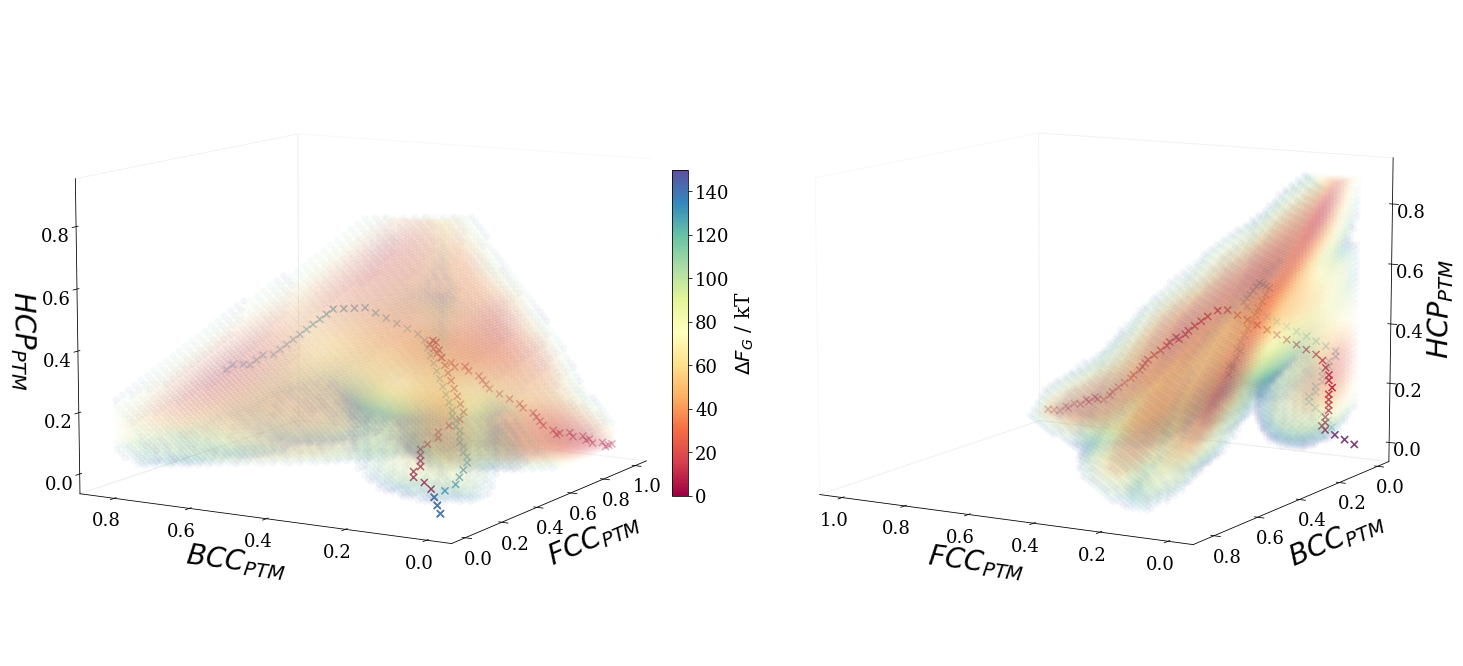

In [38]:
fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(1,2,1, projection="3d")
sub2 = fig.add_subplot(1,2,2, projection="3d")
sub1.xaxis.pane.fill = False
sub1.yaxis.pane.fill = False
sub1.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DCR_1 < 150

# Adjust scale and alpha accordingly
cp = sub1.scatter(X_cr_1, Y_cr_1, Z_cr_1, c=F3DCR_1.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=sub1, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub1.scatter(mep_coords_cr_1_fcc[:,0], mep_coords_cr_1_fcc[:,1], mep_coords_cr_1_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub1.scatter(mep_coords_cr_1_min[:,0], mep_coords_cr_1_min[:,1], mep_coords_cr_1_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub1.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub1.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub1.view_init(10, 210)
#sub1.legend()

sub2.xaxis.pane.fill = False
sub2.yaxis.pane.fill = False
sub2.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DCR_1 < 150

# Adjust scale and alpha accordingly
cp = sub2.scatter(X_cr_1, Y_cr_1, Z_cr_1, c=F3DCR_1.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
#cbar = plt.colorbar(cp, ax=sub2, fraction=0.025, pad=0.07)
#cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub2.scatter(mep_coords_cr_1_fcc[:,0], mep_coords_cr_1_fcc[:,1], mep_coords_cr_1_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub2.scatter(mep_coords_cr_1_min[:,0], mep_coords_cr_1_min[:,1], mep_coords_cr_1_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub2.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub2.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub2.view_init(10, 120)
#sub2.legend()
plt.savefig("Figs_paper/3Ds_CR_1.png", dpi=500)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9149/4196754903.py:21: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_cr_2_fcc[:,0], mep_coords_cr_2_fcc[:,1], mep_coords_cr_2_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
/tmp/ipykernel_9149/4196754903.py:22: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_cr_2_min[:,0], mep_coords_cr_2_min[:,1], mep_coords_cr_2_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")
/tmp/ipykernel_9149/4196754903.py:50: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolo

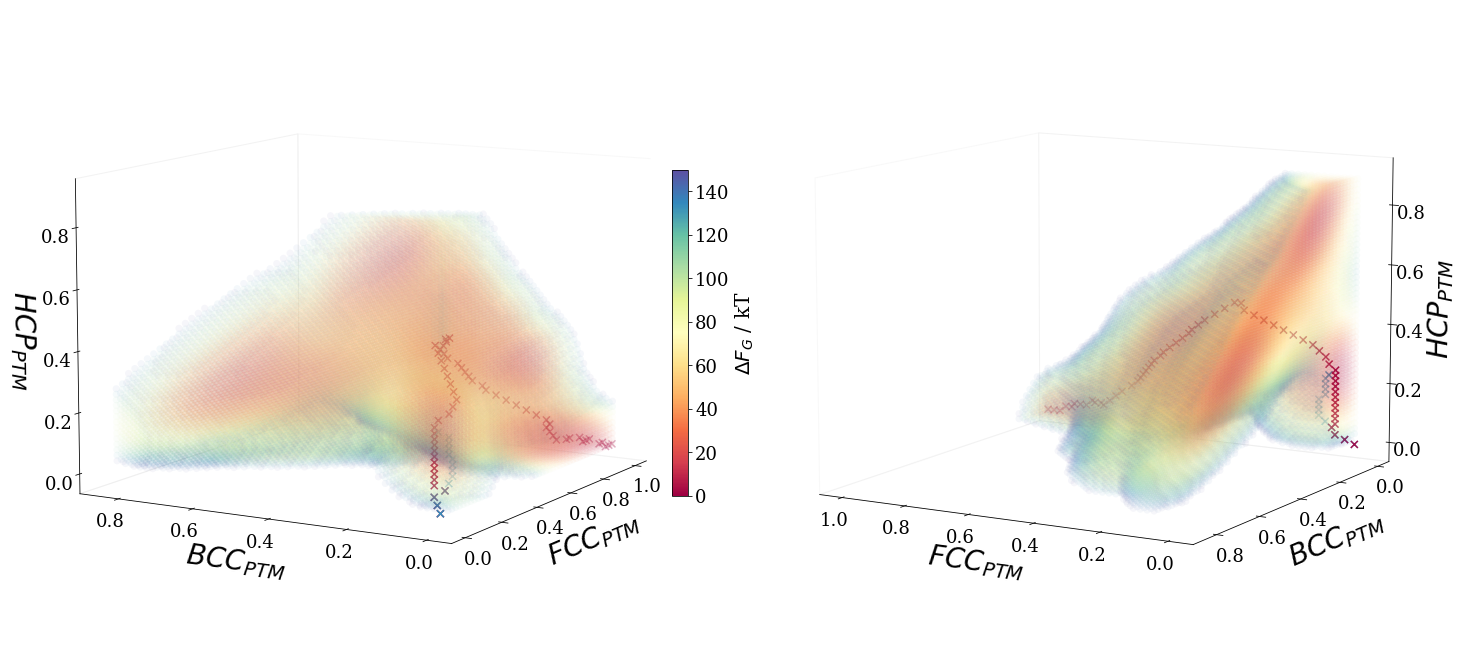

In [39]:
fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(1,2,1, projection="3d")
sub2 = fig.add_subplot(1,2,2, projection="3d")
sub1.xaxis.pane.fill = False
sub1.yaxis.pane.fill = False
sub1.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DCR_2 < 150

# Adjust scale and alpha accordingly
cp = sub1.scatter(X_cr_2, Y_cr_2, Z_cr_2, c=F3DCR_2.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=sub1, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub1.scatter(mep_coords_cr_2_fcc[:,0], mep_coords_cr_2_fcc[:,1], mep_coords_cr_2_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub1.scatter(mep_coords_cr_2_min[:,0], mep_coords_cr_2_min[:,1], mep_coords_cr_2_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub1.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub1.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub1.view_init(10, 210)
#sub1.legend()

sub2.xaxis.pane.fill = False
sub2.yaxis.pane.fill = False
sub2.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DCR_2 < 150

# Adjust scale and alpha accordingly
cp = sub2.scatter(X_cr_2, Y_cr_2, Z_cr_2, c=F3DCR_2.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
#cbar = plt.colorbar(cp, ax=sub2, fraction=0.025, pad=0.07)
#cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub2.scatter(mep_coords_cr_2_fcc[:,0], mep_coords_cr_2_fcc[:,1], mep_coords_cr_2_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub2.scatter(mep_coords_cr_2_min[:,0], mep_coords_cr_2_min[:,1], mep_coords_cr_2_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub2.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub2.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub2.view_init(10, 120)
#sub2.legend()
plt.savefig("Figs_paper/3Ds_CR_2.png", dpi=500)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9149/3721603229.py:21: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_cr_3_fcc[:,0], mep_coords_cr_3_fcc[:,1], mep_coords_cr_3_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
/tmp/ipykernel_9149/3721603229.py:22: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sub1.scatter(mep_coords_cr_3_min[:,0], mep_coords_cr_3_min[:,1], mep_coords_cr_3_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")
/tmp/ipykernel_9149/3721603229.py:50: UserWarning: You passed a edgecolor/edgecolors (['Gold']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolo

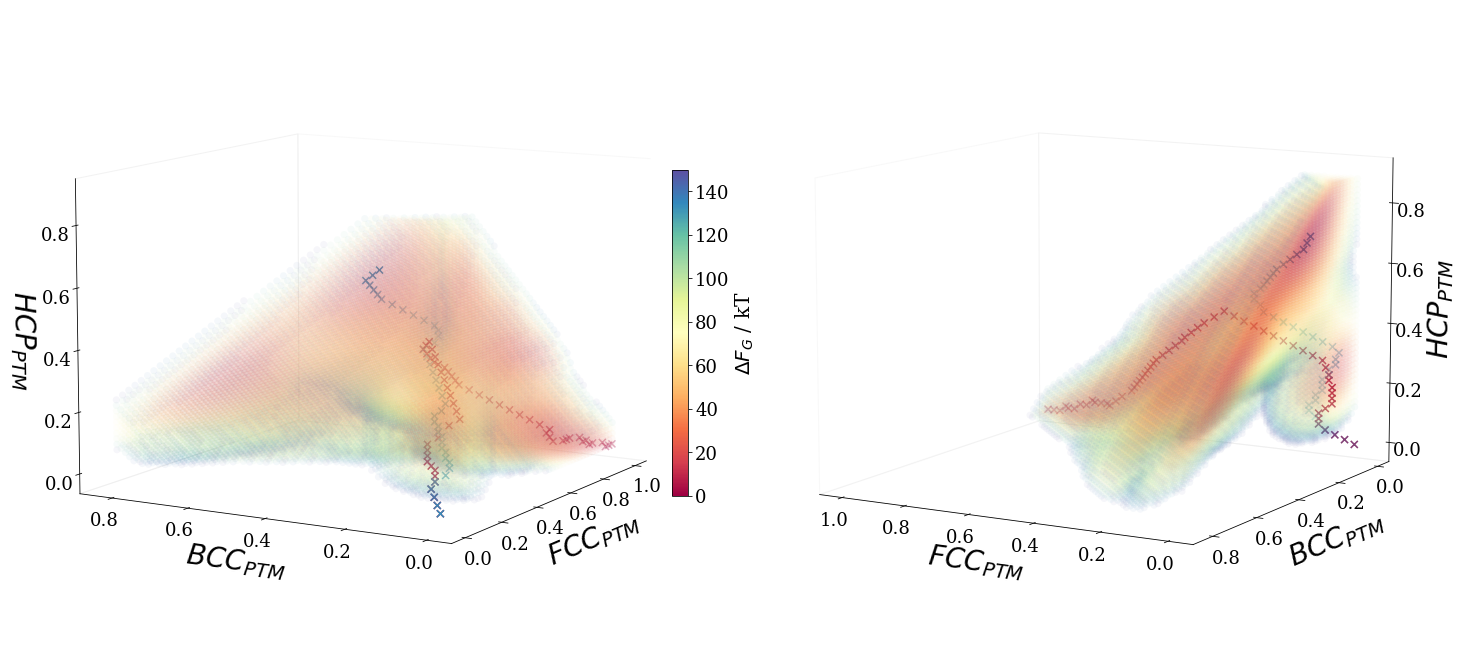

In [40]:
fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(1,2,1, projection="3d")
sub2 = fig.add_subplot(1,2,2, projection="3d")
sub1.xaxis.pane.fill = False
sub1.yaxis.pane.fill = False
sub1.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DCR_3 < 150

# Adjust scale and alpha accordingly
cp = sub1.scatter(X_cr_3, Y_cr_3, Z_cr_3, c=F3DCR_3.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=sub1, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F_G$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub1.scatter(mep_coords_cr_3_fcc[:,0], mep_coords_cr_3_fcc[:,1], mep_coords_cr_3_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub1.scatter(mep_coords_cr_3_min[:,0], mep_coords_cr_3_min[:,1], mep_coords_cr_3_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub1.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub1.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub1.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub1.view_init(10, 210)
#sub1.legend()

sub2.xaxis.pane.fill = False
sub2.yaxis.pane.fill = False
sub2.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = F3DCR_3 < 150

# Adjust scale and alpha accordingly
cp = sub2.scatter(X_cr_3, Y_cr_3, Z_cr_3, c=F3DCR_3.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
#cbar = plt.colorbar(cp, ax=sub2, fraction=0.025, pad=0.07)
#cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

sub2.scatter(mep_coords_cr_3_fcc[:,0], mep_coords_cr_3_fcc[:,1], mep_coords_cr_3_fcc[:,2], s=50, marker="x", color=cs["Bordeaux"],edgecolors=["Gold"], label="MEP to FCC")
sub2.scatter(mep_coords_cr_3_min[:,0], mep_coords_cr_3_min[:,1], mep_coords_cr_3_min[:,2], s=50, marker="x", color=cs["Blue"],edgecolors=["Gold"], label="MEP to $F_{min}$")


sub2.set_xlabel("$FCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_ylabel("$BCC_{PTM}$", fontsize=28, labelpad=15)
sub2.set_zlabel("$HCP_{PTM}$", fontsize=28, labelpad=10)
sub2.grid(False)
#plt.tight_layout()
# Rotate the axes and update
sub2.view_init(10, 120)
#sub2.legend()
plt.savefig("Figs_paper/3Ds_CR_3.png", dpi=500)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9349/3045085985.py:3: RuntimeWarning: invalid value encountered in multiply
  F = F3DL2_1*mask  # Example 3D distribution
/tmp/ipykernel_9349/3045085985.py:13: RuntimeWarning: divide by zero encountered in log
  F_xy = -kT * np.log(summed)
/tmp/ipykernel_9349/3045085985.py:17: RuntimeWarning: divide by zero encountered in log
  F_xz = -kT * np.log(summed)
/tmp/ipykernel_9349/3045085985.py:21: RuntimeWarning: divide by zero encountered in log
  F_yz = -kT * np.log(summed)


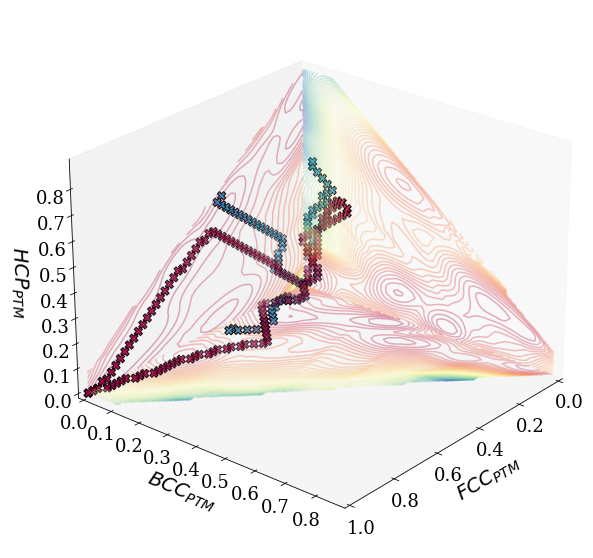

In [20]:
# Example Data: Replace with your actual data
mask = F3DL2_1 < 150
F = F3DL2_1*mask  # Example 3D distribution
mep = mep_coords_l2_1_fcc  # Example 3D path
for i in range(50):
    for j in range(50):
        for k in range(50):
            if (X_L2_1[i][j][k] + Y_L2_1[i][j][k] + Z_L2_1[i][j][k]) >= 1:
                F3DL2_1[i][j][k] = np.inf
# Compute 2D marginals
inv = np.exp(-1/kT * F3DL2_1)
summed = np.sum(inv, axis=2)
F_xy = -kT * np.log(summed)
F_xy = F_xy-np.min(F_xy)

summed = np.sum(inv, axis=1)
F_xz = -kT * np.log(summed)
F_xz = F_xz-np.min(F_xz)

summed = np.sum(inv, axis=0)
F_yz = -kT * np.log(summed)
F_yz = F_yz-np.min(F_yz)



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set view so (0,0,0) is at the back corner
ax.view_init(elev=20, azim=-120)  




# Move the marginals to the **walls**
cp = ax.contour(X_L2_1[:, :, 0], Y_L2_1[:, :, 0], F_xy.T, 50, zdir='z', offset=0, cmap='Spectral', alpha=0.35)  # Back Wall (XY at max Z)

ax.contour(X_L2_1[:, 0, :], F_xz.T, Z_L2_1[:, 0, :], 50, zdir='y', offset=0, cmap='Spectral', alpha=0.35)  # Right Wall (XZ at max Y)
ax.contour(F_yz.T, Y_L2_1[0, :, :], Z_L2_1[0, :, :], 50, zdir='x', offset=0, cmap='Spectral', alpha=0.35)  # Left Wall (YZ at max X)

# Plot the 3D path
ax.scatter(mep_coords_l2_1_fcc[:,0], mep_coords_l2_1_fcc[:,1], Z_L2_1.min(), s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_l2_1_fcc[:,0], Y_L2_1.min(), mep_coords_l2_1_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_L2_1.min(), mep_coords_l2_1_fcc[:,1], mep_coords_l2_1_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")

ax.scatter(mep_coords_l2_1_min[:,0], mep_coords_l2_1_min[:,1], Z_L2_1.min(), s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_l2_1_min[:,0], Y_L2_1.min(), mep_coords_l2_1_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_L2_1.min(), mep_coords_l2_1_min[:,1], mep_coords_l2_1_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")

# set viewing angle
ax.azim = 40    # z rotation (default=270)
ax.elev = 25    # x rotation (default=0)
ax.dist = 10    # zoom (define perspective)

# Labels and Limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([X_L2_1.min(), X_L2_1.max()])
ax.set_ylim([Y_L2_1.min(), Y_L2_1.max()])
ax.set_zlim([Z_L2_1.min(), Z_L2_1.max()])
#plt.legend()
ax.grid(False)
ax.set_xlabel("$FCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_ylabel("$BCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_zlabel("$HCP_{PTM}$", fontsize=20, labelpad=10)

#plt.tight_layout()
plt.savefig("Figs_paper/L2_1_3D_marginals.png", dpi=500)
plt.show()

/tmp/ipykernel_9349/387834818.py:3: RuntimeWarning: invalid value encountered in multiply
  F = F3DL2_2*mask  # Example 3D distribution
/tmp/ipykernel_9349/387834818.py:13: RuntimeWarning: divide by zero encountered in log
  F_xy = -kT * np.log(summed)
/tmp/ipykernel_9349/387834818.py:17: RuntimeWarning: divide by zero encountered in log
  F_xz = -kT * np.log(summed)
/tmp/ipykernel_9349/387834818.py:21: RuntimeWarning: divide by zero encountered in log
  F_yz = -kT * np.log(summed)


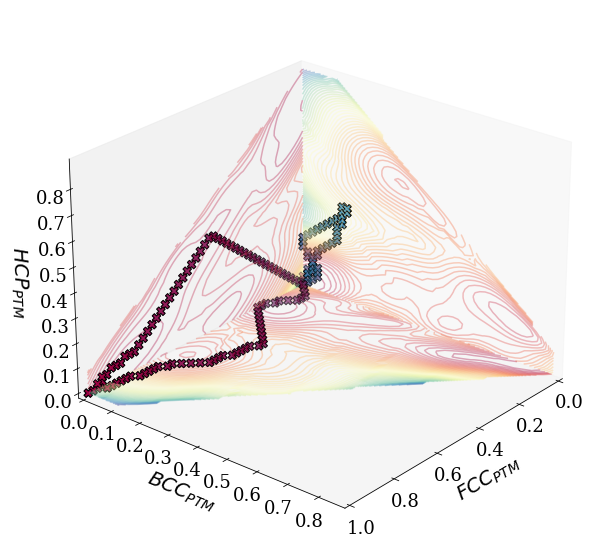

In [21]:
# Example Data: Replace with your actual data
mask = F3DL2_2 < 150
F = F3DL2_2*mask  # Example 3D distribution
mep = mep_coords_l2_2_fcc  # Example 3D path
for i in range(50):
    for j in range(50):
        for k in range(50):
            if (X_L2_2[i][j][k] + Y_L2_2[i][j][k] + Z_L2_2[i][j][k]) >= 1:
                F3DL2_2[i][j][k] = np.inf
# Compute 2D marginals
inv = np.exp(-1/kT * F3DL2_2)
summed = np.sum(inv, axis=2)
F_xy = -kT * np.log(summed)
F_xy = F_xy-np.min(F_xy)

summed = np.sum(inv, axis=1)
F_xz = -kT * np.log(summed)
F_xz = F_xz-np.min(F_xz)

summed = np.sum(inv, axis=0)
F_yz = -kT * np.log(summed)
F_yz = F_yz-np.min(F_yz)



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set view so (0,0,0) is at the back corner
ax.view_init(elev=20, azim=-120)  




# Move the marginals to the **walls**
cp = ax.contour(X_L2_2[:, :, 0], Y_L2_2[:, :, 0], F_xy.T, 50, zdir='z', offset=0, cmap='Spectral', alpha=0.35)  # Back Wall (XY at max Z)

ax.contour(X_L2_2[:, 0, :], F_xz.T, Z_L2_2[:, 0, :], 50, zdir='y', offset=0, cmap='Spectral', alpha=0.35)  # Right Wall (XZ at max Y)
ax.contour(F_yz.T, Y_L2_2[0, :, :], Z_L2_2[0, :, :], 50, zdir='x', offset=0, cmap='Spectral', alpha=0.35)  # Left Wall (YZ at max X)

# Plot the 3D path
ax.scatter(mep_coords_l2_2_fcc[:,0], mep_coords_l2_2_fcc[:,1], Z_L2_2.min(), s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_l2_2_fcc[:,0], Y_L2_2.min(), mep_coords_l2_2_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_L2_2.min(), mep_coords_l2_2_fcc[:,1], mep_coords_l2_2_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")

ax.scatter(mep_coords_l2_2_min[:,0], mep_coords_l2_2_min[:,1], Z_L2_2.min(), s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_l2_2_min[:,0], Y_L2_2.min(), mep_coords_l2_2_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_L2_2.min(), mep_coords_l2_2_min[:,1], mep_coords_l2_2_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")

# set viewing angle
ax.azim = 40    # z rotation (default=270)
ax.elev = 25    # x rotation (default=0)
ax.dist = 10    # zoom (define perspective)

# Labels and Limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([X_L2_2.min(), X_L2_2.max()])
ax.set_ylim([Y_L2_2.min(), Y_L2_2.max()])
ax.set_zlim([Z_L2_2.min(), Z_L2_2.max()])
#plt.legend()
ax.grid(False)
ax.set_xlabel("$FCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_ylabel("$BCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_zlabel("$HCP_{PTM}$", fontsize=20, labelpad=10)

#plt.tight_layout()
plt.savefig("Figs_paper/L2_2_3D_marginals.png", dpi=500)
plt.show()

/tmp/ipykernel_9349/4279617317.py:3: RuntimeWarning: invalid value encountered in multiply
  F = F3DL2_3*mask  # Example 3D distribution
/tmp/ipykernel_9349/4279617317.py:13: RuntimeWarning: divide by zero encountered in log
  F_xy = -kT * np.log(summed)
/tmp/ipykernel_9349/4279617317.py:17: RuntimeWarning: divide by zero encountered in log
  F_xz = -kT * np.log(summed)
/tmp/ipykernel_9349/4279617317.py:21: RuntimeWarning: divide by zero encountered in log
  F_yz = -kT * np.log(summed)


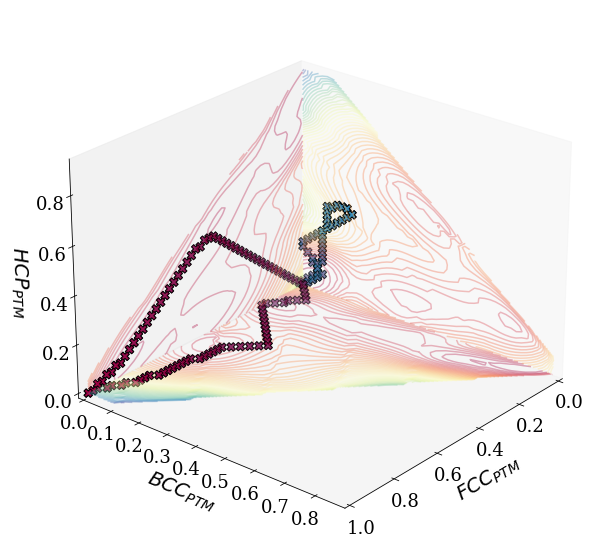

In [22]:
# Example Data: Replace with your actual data
mask = F3DL2_3 < 150
F = F3DL2_3*mask  # Example 3D distribution
mep = mep_coords_l2_3_fcc  # Example 3D path
for i in range(50):
    for j in range(50):
        for k in range(50):
            if (X_L2_3[i][j][k] + Y_L2_3[i][j][k] + Z_L2_3[i][j][k]) >= 1:
                F3DL2_3[i][j][k] = np.inf
# Compute 2D marginals
inv = np.exp(-1/kT * F3DL2_3)
summed = np.sum(inv, axis=2)
F_xy = -kT * np.log(summed)
F_xy = F_xy-np.min(F_xy)

summed = np.sum(inv, axis=1)
F_xz = -kT * np.log(summed)
F_xz = F_xz-np.min(F_xz)

summed = np.sum(inv, axis=0)
F_yz = -kT * np.log(summed)
F_yz = F_yz-np.min(F_yz)



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set view so (0,0,0) is at the back corner
ax.view_init(elev=20, azim=-120)  




# Move the marginals to the **walls**
cp = ax.contour(X_L2_3[:, :, 0], Y_L2_3[:, :, 0], F_xy.T, 50, zdir='z', offset=0, cmap='Spectral', alpha=0.35)  # Back Wall (XY at max Z)

ax.contour(X_L2_3[:, 0, :], F_xz.T, Z_L2_3[:, 0, :], 50, zdir='y', offset=0, cmap='Spectral', alpha=0.35)  # Right Wall (XZ at max Y)
ax.contour(F_yz.T, Y_L2_3[0, :, :], Z_L2_3[0, :, :], 50, zdir='x', offset=0, cmap='Spectral', alpha=0.35)  # Left Wall (YZ at max X)

# Plot the 3D path
ax.scatter(mep_coords_l2_3_fcc[:,0], mep_coords_l2_3_fcc[:,1], Z_L2_3.min(), s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_l2_3_fcc[:,0], Y_L2_3.min(), mep_coords_l2_3_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_L2_3.min(), mep_coords_l2_3_fcc[:,1], mep_coords_l2_3_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")

ax.scatter(mep_coords_l2_3_min[:,0], mep_coords_l2_3_min[:,1], Z_L2_3.min(), s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_l2_3_min[:,0], Y_L2_3.min(), mep_coords_l2_3_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_L2_3.min(), mep_coords_l2_3_min[:,1], mep_coords_l2_3_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")

# set viewing angle
ax.azim = 40    # z rotation (default=270)
ax.elev = 25    # x rotation (default=0)
ax.dist = 10    # zoom (define perspective)

# Labels and Limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([X_L2_3.min(), X_L2_3.max()])
ax.set_ylim([Y_L2_3.min(), Y_L2_3.max()])
ax.set_zlim([Z_L2_3.min(), Z_L2_3.max()])
#plt.legend()
ax.grid(False)
ax.set_xlabel("$FCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_ylabel("$BCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_zlabel("$HCP_{PTM}$", fontsize=20, labelpad=10)

#plt.tight_layout()
plt.savefig("Figs_paper/L2_3_3D_marginals.png", dpi=500)
plt.show()

/tmp/ipykernel_9349/3985408954.py:3: RuntimeWarning: invalid value encountered in multiply
  F = F3DCR_1*mask  # Example 3D distribution
/tmp/ipykernel_9349/3985408954.py:13: RuntimeWarning: divide by zero encountered in log
  F_xy = -kT * np.log(summed)
/tmp/ipykernel_9349/3985408954.py:17: RuntimeWarning: divide by zero encountered in log
  F_xz = -kT * np.log(summed)
/tmp/ipykernel_9349/3985408954.py:21: RuntimeWarning: divide by zero encountered in log
  F_yz = -kT * np.log(summed)


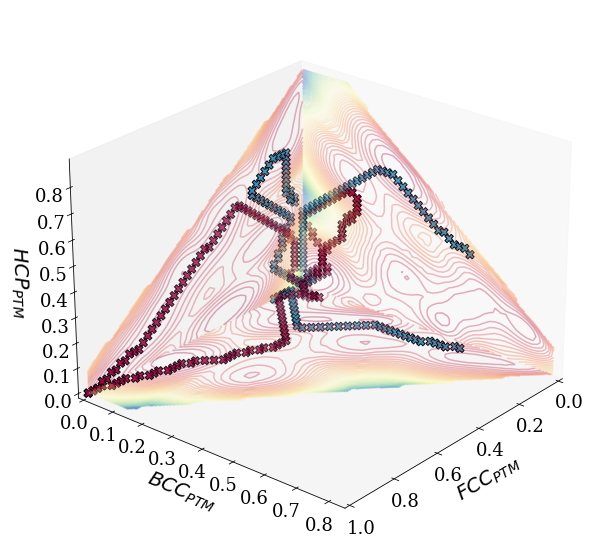

In [23]:
# Example Data: Replace with your actual data
mask = F3DCR_1 < 150
F = F3DCR_1*mask  # Example 3D distribution
mep = mep_coords_cr_1_fcc  # Example 3D path
for i in range(50):
    for j in range(50):
        for k in range(50):
            if (X_cr_1[i][j][k] + Y_cr_1[i][j][k] + Z_cr_1[i][j][k]) >= 1:
                F3DCR_1[i][j][k] = np.inf
# Compute 2D marginals
inv = np.exp(-1/kT * F3DCR_1)
summed = np.sum(inv, axis=2)
F_xy = -kT * np.log(summed)
F_xy = F_xy-np.min(F_xy)

summed = np.sum(inv, axis=1)
F_xz = -kT * np.log(summed)
F_xz = F_xz-np.min(F_xz)

summed = np.sum(inv, axis=0)
F_yz = -kT * np.log(summed)
F_yz = F_yz-np.min(F_yz)



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set view so (0,0,0) is at the back corner
ax.view_init(elev=20, azim=-120)  




# Move the marginals to the **walls**
cp = ax.contour(X_cr_1[:, :, 0], Y_cr_1[:, :, 0], F_xy.T, 50, zdir='z', offset=0, cmap='Spectral', alpha=0.35)  # Back Wall (XY at max Z)

ax.contour(X_cr_1[:, 0, :], F_xz.T, Z_cr_1[:, 0, :], 50, zdir='y', offset=0, cmap='Spectral', alpha=0.35)  # Right Wall (XZ at max Y)
ax.contour(F_yz.T, Y_cr_1[0, :, :], Z_cr_1[0, :, :], 50, zdir='x', offset=0, cmap='Spectral', alpha=0.35)  # Left Wall (YZ at max X)

# Plot the 3D path
ax.scatter(mep_coords_cr_1_fcc[:,0], mep_coords_cr_1_fcc[:,1], Z_cr_1.min(), s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_cr_1_fcc[:,0], Y_cr_1.min(), mep_coords_cr_1_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_cr_1.min(), mep_coords_cr_1_fcc[:,1], mep_coords_cr_1_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")

ax.scatter(mep_coords_cr_1_min[:,0], mep_coords_cr_1_min[:,1], Z_cr_1.min(), s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_cr_1_min[:,0], Y_cr_1.min(), mep_coords_cr_1_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_cr_1.min(), mep_coords_cr_1_min[:,1], mep_coords_cr_1_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")

# set viewing angle
ax.azim = 40    # z rotation (default=270)
ax.elev = 25    # x rotation (default=0)
ax.dist = 10    # zoom (define perspective)

# Labels and Limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([X_cr_1.min(), X_cr_1.max()])
ax.set_ylim([Y_cr_1.min(), Y_cr_1.max()])
ax.set_zlim([Z_cr_1.min(), Z_cr_1.max()])
#plt.legend()
ax.grid(False)
ax.set_xlabel("$FCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_ylabel("$BCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_zlabel("$HCP_{PTM}$", fontsize=20, labelpad=10)

#plt.tight_layout()
plt.savefig("Figs_paper/CR_1_3D_marginals.png", dpi=500)
plt.show()

/tmp/ipykernel_9349/473717812.py:3: RuntimeWarning: invalid value encountered in multiply
  F = F3DCR_2*mask  # Example 3D distribution
/tmp/ipykernel_9349/473717812.py:13: RuntimeWarning: divide by zero encountered in log
  F_xy = -kT * np.log(summed)
/tmp/ipykernel_9349/473717812.py:17: RuntimeWarning: divide by zero encountered in log
  F_xz = -kT * np.log(summed)
/tmp/ipykernel_9349/473717812.py:21: RuntimeWarning: divide by zero encountered in log
  F_yz = -kT * np.log(summed)


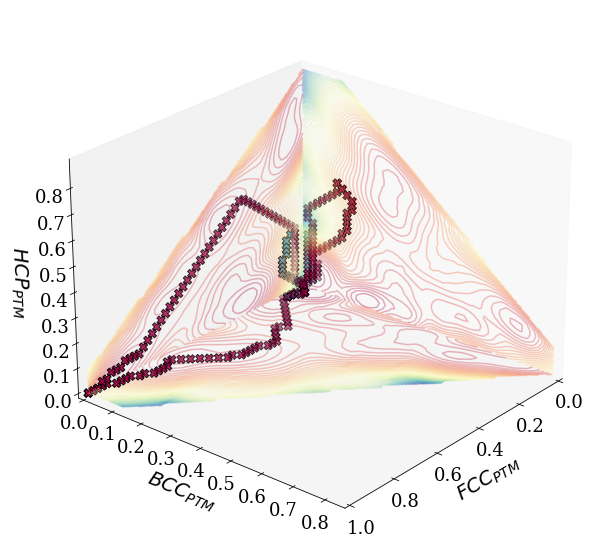

In [24]:
# Example Data: Replace with your actual data
mask = F3DCR_2 < 150
F = F3DCR_2*mask  # Example 3D distribution
mep = mep_coords_cr_2_fcc  # Example 3D path
for i in range(50):
    for j in range(50):
        for k in range(50):
            if (X_cr_2[i][j][k] + Y_cr_2[i][j][k] + Z_cr_2[i][j][k]) >= 1:
                F3DCR_2[i][j][k] = np.inf
# Compute 2D marginals
inv = np.exp(-1/kT * F3DCR_2)
summed = np.sum(inv, axis=2)
F_xy = -kT * np.log(summed)
F_xy = F_xy-np.min(F_xy)

summed = np.sum(inv, axis=1)
F_xz = -kT * np.log(summed)
F_xz = F_xz-np.min(F_xz)

summed = np.sum(inv, axis=0)
F_yz = -kT * np.log(summed)
F_yz = F_yz-np.min(F_yz)



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set view so (0,0,0) is at the back corner
ax.view_init(elev=20, azim=-120)  




# Move the marginals to the **walls**
cp = ax.contour(X_cr_2[:, :, 0], Y_cr_2[:, :, 0], F_xy.T, 50, zdir='z', offset=0, cmap='Spectral', alpha=0.35)  # Back Wall (XY at max Z)

ax.contour(X_cr_2[:, 0, :], F_xz.T, Z_cr_2[:, 0, :], 50, zdir='y', offset=0, cmap='Spectral', alpha=0.35)  # Right Wall (XZ at max Y)
ax.contour(F_yz.T, Y_cr_2[0, :, :], Z_cr_2[0, :, :], 50, zdir='x', offset=0, cmap='Spectral', alpha=0.35)  # Left Wall (YZ at max X)

# Plot the 3D path
ax.scatter(mep_coords_cr_2_fcc[:,0], mep_coords_cr_2_fcc[:,1], Z_cr_2.min(), s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_cr_2_fcc[:,0], Y_cr_2.min(), mep_coords_cr_2_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_cr_2.min(), mep_coords_cr_2_fcc[:,1], mep_coords_cr_2_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")

ax.scatter(mep_coords_cr_2_min[:,0], mep_coords_cr_2_min[:,1], Z_cr_2.min(), s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_cr_2_min[:,0], Y_cr_2.min(), mep_coords_cr_2_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_cr_2.min(), mep_coords_cr_2_min[:,1], mep_coords_cr_2_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")

# set viewing angle
ax.azim = 40    # z rotation (default=270)
ax.elev = 25    # x rotation (default=0)
ax.dist = 10    # zoom (define perspective)

# Labels and Limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([X_cr_2.min(), X_cr_2.max()])
ax.set_ylim([Y_cr_2.min(), Y_cr_2.max()])
ax.set_zlim([Z_cr_2.min(), Z_cr_2.max()])
#plt.legend()
ax.grid(False)
ax.set_xlabel("$FCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_ylabel("$BCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_zlabel("$HCP_{PTM}$", fontsize=20, labelpad=10)

#plt.tight_layout()
plt.savefig("Figs_paper/CR_2_3D_marginals.png", dpi=500)
plt.show()

/tmp/ipykernel_9349/3481909318.py:3: RuntimeWarning: invalid value encountered in multiply
  F = F3DCR_3*mask  # Example 3D distribution
/tmp/ipykernel_9349/3481909318.py:13: RuntimeWarning: divide by zero encountered in log
  F_xy = -kT * np.log(summed)
/tmp/ipykernel_9349/3481909318.py:17: RuntimeWarning: divide by zero encountered in log
  F_xz = -kT * np.log(summed)
/tmp/ipykernel_9349/3481909318.py:21: RuntimeWarning: divide by zero encountered in log
  F_yz = -kT * np.log(summed)


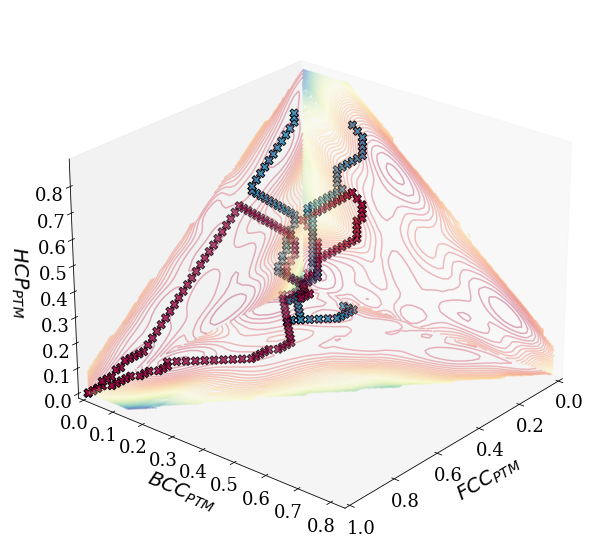

In [25]:
# Example Data: Replace with your actual data
mask = F3DCR_3 < 150
F = F3DCR_3*mask  # Example 3D distribution
mep = mep_coords_cr_3_fcc  # Example 3D path
for i in range(50):
    for j in range(50):
        for k in range(50):
            if (X_cr_3[i][j][k] + Y_cr_3[i][j][k] + Z_cr_3[i][j][k]) >= 1:
                F3DCR_3[i][j][k] = np.inf
# Compute 2D marginals
inv = np.exp(-1/kT * F3DCR_3)
summed = np.sum(inv, axis=2)
F_xy = -kT * np.log(summed)
F_xy = F_xy-np.min(F_xy)

summed = np.sum(inv, axis=1)
F_xz = -kT * np.log(summed)
F_xz = F_xz-np.min(F_xz)

summed = np.sum(inv, axis=0)
F_yz = -kT * np.log(summed)
F_yz = F_yz-np.min(F_yz)



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set view so (0,0,0) is at the back corner
ax.view_init(elev=20, azim=-120)  




# Move the marginals to the **walls**
cp = ax.contour(X_cr_3[:, :, 0], Y_cr_3[:, :, 0], F_xy.T, 50, zdir='z', offset=0, cmap='Spectral', alpha=0.35)  # Back Wall (XY at max Z)

ax.contour(X_cr_3[:, 0, :], F_xz.T, Z_cr_3[:, 0, :], 50, zdir='y', offset=0, cmap='Spectral', alpha=0.35)  # Right Wall (XZ at max Y)
ax.contour(F_yz.T, Y_cr_3[0, :, :], Z_cr_3[0, :, :], 50, zdir='x', offset=0, cmap='Spectral', alpha=0.35)  # Left Wall (YZ at max X)

# Plot the 3D path
ax.scatter(mep_coords_cr_3_fcc[:,0], mep_coords_cr_3_fcc[:,1], Z_cr_3.min(), s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_cr_3_fcc[:,0], Y_cr_3.min(), mep_coords_cr_3_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_cr_3.min(), mep_coords_cr_3_fcc[:,1], mep_coords_cr_3_fcc[:,2], s=70, marker="X", color=cs["Bordeaux"],edgecolors="black",linewidths=1, label="MEP")

ax.scatter(mep_coords_cr_3_min[:,0], mep_coords_cr_3_min[:,1], Z_cr_3.min(), s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(mep_coords_cr_3_min[:,0], Y_cr_3.min(), mep_coords_cr_3_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")
ax.scatter(X_cr_3.min(), mep_coords_cr_3_min[:,1], mep_coords_cr_3_min[:,2], s=70, marker="X", color=cs["Blue"],edgecolors="black",linewidths=1, label="MEP")

# set viewing angle
ax.azim = 40    # z rotation (default=270)
ax.elev = 25    # x rotation (default=0)
ax.dist = 10    # zoom (define perspective)

# Labels and Limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([X_cr_3.min(), X_cr_3.max()])
ax.set_ylim([Y_cr_3.min(), Y_cr_3.max()])
ax.set_zlim([Z_cr_3.min(), Z_cr_3.max()])
#plt.legend()
ax.grid(False)
ax.set_xlabel("$FCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_ylabel("$BCC_{PTM}$", fontsize=20, labelpad=10)
ax.set_zlabel("$HCP_{PTM}$", fontsize=20, labelpad=10)

#plt.tight_layout()
plt.savefig("Figs_paper/CR_3_3D_marginals.png", dpi=500)
plt.show()

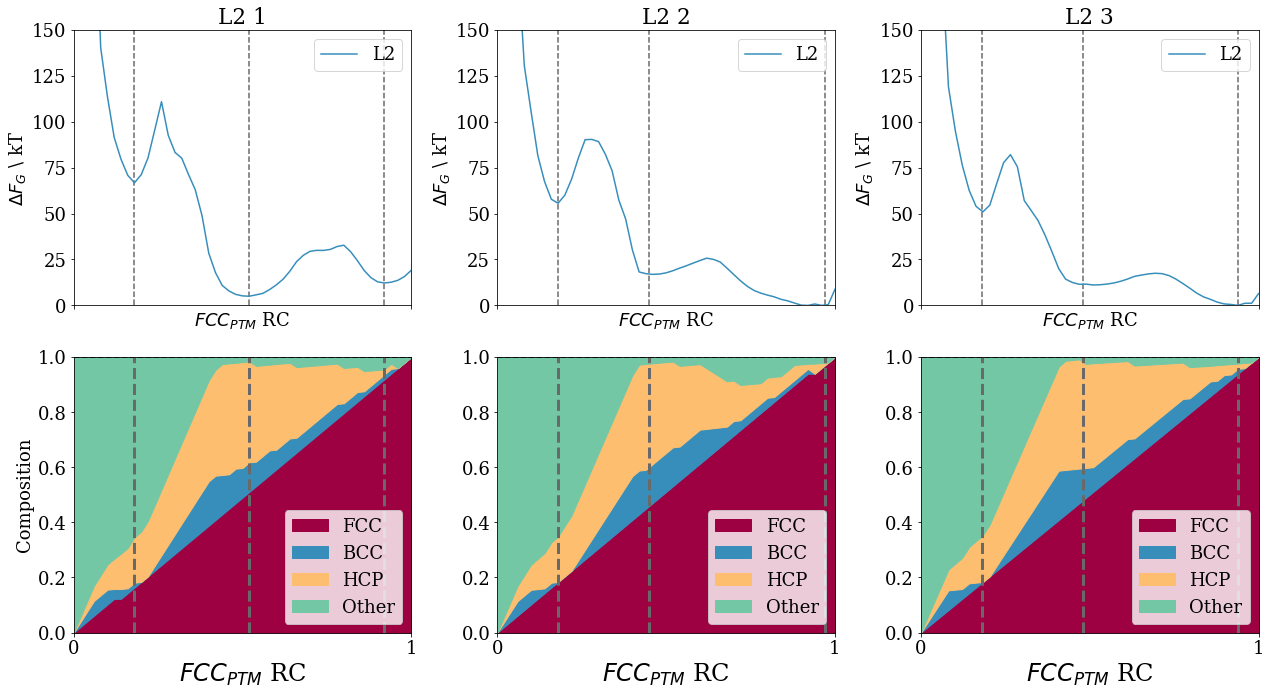

In [22]:
fig, axs = plt.subplots(2,3, figsize=(18,10), sharex=True)

MEPL2_1 = []
for pat in mep_l2_1_fcc:
    MEPL2_1.append(F3DL2_1[pat])
    
MEPL2_2 = []
for pat in mep_l2_2_fcc:
    MEPL2_2.append(F3DL2_2[pat])

MEPL2_3 = []
for pat in mep_l2_3_fcc:
    MEPL2_3.append(F3DL2_3[pat])

x = np.linspace(0,1,len(MEPL2_1))
axs[0,0].plot(x,MEPL2_1, color=cs["Blue"], label="L2")
axs[0,0].set_ylim(0,150)
axs[0,0].set_xticks([0,1])
axs[0,0].vlines(0.18, 0,150, linestyle="dashed", color="dimgrey")
axs[0,0].vlines(0.52, 0,150, linestyle="dashed", color="dimgrey")
axs[0,0].vlines(0.92, 0,150, linestyle="dashed", color="dimgrey")


#axs[0].set_xticklabels([0,1])
axs[0,0].set_xlabel("$FCC_{PTM}$ RC")
axs[0,0].set_ylabel("$\Delta F_G$ \ kT")

axs[0,0].legend()

x = np.linspace(0,1, len(MEPL2_2))
axs[0,1].plot(x,MEPL2_2, color=cs["Blue"], label="L2")
axs[0,1].set_ylim(0,150)
axs[0,1].set_xticks([0,1])
#axs[0].set_xticklabels([0,1])
axs[0,1].set_xlabel("$FCC_{PTM}$ RC")
axs[0,1].set_ylabel("$\Delta F_G$ \ kT")
axs[0,1].vlines(0.181, 0,150, linestyle="dashed", color="dimgrey")
axs[0,1].vlines(0.45, 0,150, linestyle="dashed", color="dimgrey")
axs[0,1].vlines(0.97, 0,150, linestyle="dashed", color="dimgrey")

axs[0,1].legend()


x = np.linspace(0,1, len(MEPL2_3))
axs[0,2].plot(x,MEPL2_3, color=cs["Blue"], label="L2")
axs[0,2].set_ylim(0,150)
axs[0,2].set_xticks([0,1])
#axs[0].set_xticklabels([0,1])
axs[0,2].set_xlabel("$FCC_{PTM}$ RC")
axs[0,2].set_ylabel("$\Delta F_G$ \ kT")
axs[0,2].vlines(0.181, 0,150, linestyle="dashed", color="dimgrey")
axs[0,2].vlines(0.48, 0,150, linestyle="dashed", color="dimgrey")
axs[0,2].vlines(0.94, 0,150, linestyle="dashed", color="dimgrey")

axs[0,2].legend()


axs[1,0].hlines(1, 0, len(mep_coords_l2_1_fcc), linestyle="dashed", color="black")
x = np.linspace(0,1,len(MEPL2_1))

axs[1,0].fill_between(x, mep_coords_l2_1_fcc[:,0], color=cs["Bordeaux"], label="FCC")

axs[1,0].fill_between(x, mep_coords_l2_1_fcc[:,0], mep_coords_l2_1_fcc[:,0]+mep_coords_l2_1_fcc[:,1], color=cs["Blue"], label="BCC")

axs[1,0].fill_between(x, mep_coords_l2_1_fcc[:,0]+mep_coords_l2_1_fcc[:,1], mep_coords_l2_1_fcc[:,0]+mep_coords_l2_1_fcc[:,1]+mep_coords_l2_1_fcc[:,2], color=cs["Gold"], label="HCP")

axs[1,0].fill_between(x, mep_coords_l2_1_fcc[:,0]+mep_coords_l2_1_fcc[:,1]+mep_coords_l2_1_fcc[:,2], np.ones(len(mep_coords_l2_1_fcc)), color=cs["Teal"], label="Other")
axs[1,0].legend(loc="lower right")

axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(0,1)
axs[1,0].set_xticklabels([0,1])
axs[1,0].set_ylabel("Composition")
axs[1,0].set_xlabel("$FCC_{PTM}$ RC", fontsize=24)
axs[0,0].set_title("L2 1")
axs[1,0].vlines(0.18, 0,150, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,0].vlines(0.52, 0,150, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,0].vlines(0.92, 0,150, linestyle="dashed", color="dimgrey", linewidth=3)

x = np.linspace(0,1, len(MEPL2_2))

axs[1,1].hlines(1, 0, len(mep_coords_l2_2_fcc), linestyle="dashed", color="black")

axs[1,1].fill_between(x, mep_coords_l2_2_fcc[:,0], color=cs["Bordeaux"], label="FCC")

axs[1,1].fill_between(x, mep_coords_l2_2_fcc[:,0], mep_coords_l2_2_fcc[:,0]+mep_coords_l2_2_fcc[:,1], color=cs["Blue"], label="BCC")

axs[1,1].fill_between(x, mep_coords_l2_2_fcc[:,0]+mep_coords_l2_2_fcc[:,1], mep_coords_l2_2_fcc[:,0]+mep_coords_l2_2_fcc[:,1]+mep_coords_l2_2_fcc[:,2], color=cs["Gold"], label="HCP")

axs[1,1].fill_between(x, mep_coords_l2_2_fcc[:,0]+mep_coords_l2_2_fcc[:,1]+mep_coords_l2_2_fcc[:,2], np.ones(len(mep_coords_l2_2_fcc)), color=cs["Teal"], label="Other")
axs[1,1].legend(loc="lower right")

axs[1,1].set_xticklabels([0,1])
axs[1,1].set_xlim(0,1)
axs[1,1].set_ylim(0,1)
axs[1,1].set_xlabel("$FCC_{PTM}$ RC", fontsize=24)
axs[0,1].set_title("L2 2")
axs[1,1].vlines(0.181, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,1].vlines(0.45, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,1].vlines(0.97, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)


x = np.linspace(0,1, len(MEPL2_3))

axs[1,2].hlines(1, 0, len(mep_coords_l2_3_fcc), linestyle="dashed", color="black")

axs[1,2].fill_between(x, mep_coords_l2_3_fcc[:,0], color=cs["Bordeaux"], label="FCC")

axs[1,2].fill_between(x, mep_coords_l2_3_fcc[:,0], mep_coords_l2_3_fcc[:,0]+mep_coords_l2_3_fcc[:,1], color=cs["Blue"], label="BCC")

axs[1,2].fill_between(x, mep_coords_l2_3_fcc[:,0]+mep_coords_l2_3_fcc[:,1], mep_coords_l2_3_fcc[:,0]+mep_coords_l2_3_fcc[:,1]+mep_coords_l2_3_fcc[:,2], color=cs["Gold"], label="HCP")

axs[1,2].fill_between(x, mep_coords_l2_3_fcc[:,0]+mep_coords_l2_3_fcc[:,1]+mep_coords_l2_3_fcc[:,2], np.ones(len(mep_coords_l2_3_fcc)), color=cs["Teal"], label="Other")
axs[1,2].legend(loc="lower right")

axs[1,2].set_xticklabels([0,1])
axs[1,2].set_xlim(0,1)
axs[1,2].set_ylim(0,1)
axs[1,2].set_xlabel("$FCC_{PTM}$ RC", fontsize=24)
axs[0,2].set_title("L2 3")
axs[1,2].vlines(0.181, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,2].vlines(0.48, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,2].vlines(0.94, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
plt.tight_layout()
#plt.savefig("Figs_paper/RC_composition_L2.png", dpi=500)

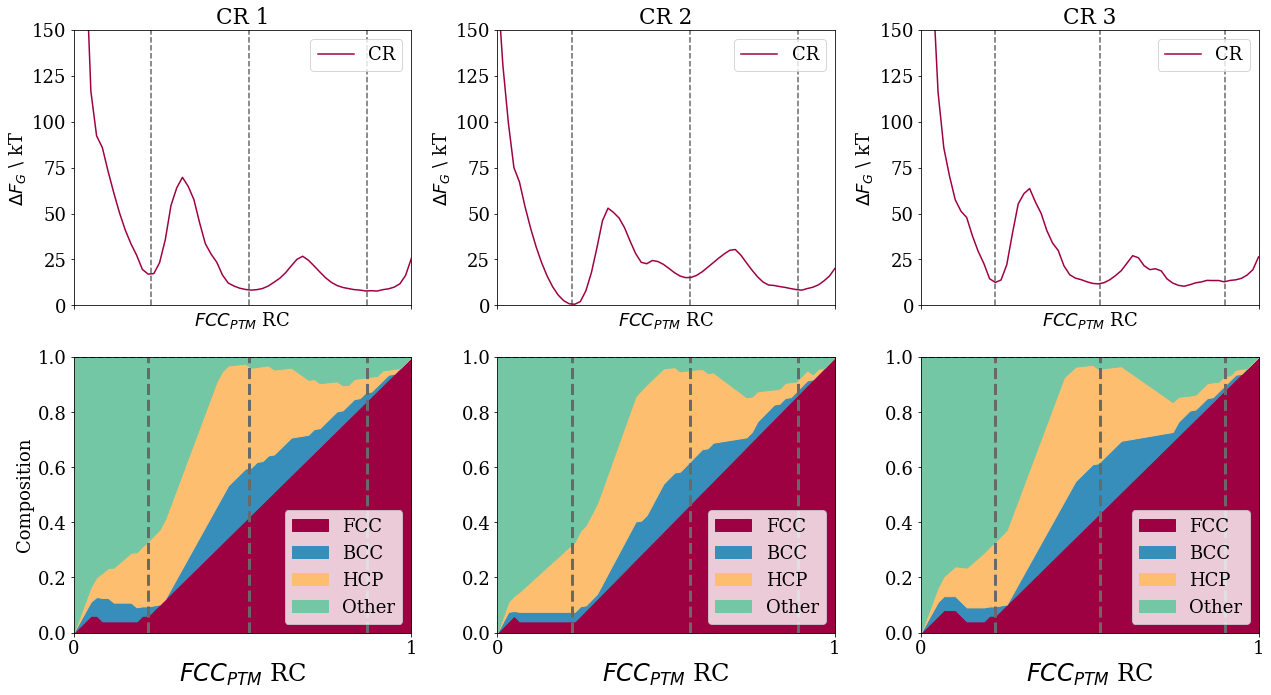

In [20]:
fig, axs = plt.subplots(2,3, figsize=(18,10), sharex=True)

MEPCR_1 = []
for pat in mep_cr_1_fcc:
    MEPCR_1.append(F3DCR_1[pat])
    
MEPCR_2 = []
for pat in mep_cr_2_fcc:
    MEPCR_2.append(F3DCR_2[pat])

MEPCR_3 = []
for pat in mep_cr_3_fcc:
    MEPCR_3.append(F3DCR_3[pat])

x = np.linspace(0,1,len(MEPCR_1))
axs[0,0].plot(x,MEPCR_1, color=cs["Bordeaux"], label="CR")
axs[0,0].set_ylim(0,150)
axs[0,0].set_xticks([0,1])
axs[0,0].vlines(0.23, 0,150, linestyle="dashed", color="dimgrey")
axs[0,0].vlines(0.52, 0,150, linestyle="dashed", color="dimgrey")
axs[0,0].vlines(0.87, 0,150, linestyle="dashed", color="dimgrey")


#axs[0].set_xticklabels([0,1])
axs[0,0].set_xlabel("$FCC_{PTM}$ RC")
axs[0,0].set_ylabel("$\Delta F_G$ \ kT")

axs[0,0].legend()

x = np.linspace(0,1, len(MEPCR_2))
axs[0,1].plot(x,MEPCR_2, color=cs["Bordeaux"], label="CR")
axs[0,1].set_ylim(0,150)
axs[0,1].set_xticks([0,1])
#axs[0].set_xticklabels([0,1])
axs[0,1].set_xlabel("$FCC_{PTM}$ RC")
axs[0,1].set_ylabel("$\Delta F_G$ \ kT")
axs[0,1].vlines(0.22, 0,150, linestyle="dashed", color="dimgrey")
axs[0,1].vlines(0.57, 0,150, linestyle="dashed", color="dimgrey")
axs[0,1].vlines(0.89, 0,150, linestyle="dashed", color="dimgrey")

axs[0,1].legend()


x = np.linspace(0,1, len(MEPCR_3))
axs[0,2].plot(x,MEPCR_3, color=cs["Bordeaux"], label="CR")
axs[0,2].set_ylim(0,150)
axs[0,2].set_xticks([0,1])
#axs[0].set_xticklabels([0,1])
axs[0,2].set_xlabel("$FCC_{PTM}$ RC")
axs[0,2].set_ylabel("$\Delta F_G$ \ kT")
axs[0,2].vlines(0.22, 0,150, linestyle="dashed", color="dimgrey")
axs[0,2].vlines(0.53, 0,150, linestyle="dashed", color="dimgrey")
axs[0,2].vlines(0.9, 0,150, linestyle="dashed", color="dimgrey")

axs[0,2].legend()


axs[1,0].hlines(1, 0, len(mep_coords_cr_1_fcc), linestyle="dashed", color="black")
x = np.linspace(0,1,len(MEPCR_1))

axs[1,0].fill_between(x, mep_coords_cr_1_fcc[:,0], color=cs["Bordeaux"], label="FCC")

axs[1,0].fill_between(x, mep_coords_cr_1_fcc[:,0], mep_coords_cr_1_fcc[:,0]+mep_coords_cr_1_fcc[:,1], color=cs["Blue"], label="BCC")

axs[1,0].fill_between(x, mep_coords_cr_1_fcc[:,0]+mep_coords_cr_1_fcc[:,1], mep_coords_cr_1_fcc[:,0]+mep_coords_cr_1_fcc[:,1]+mep_coords_cr_1_fcc[:,2], color=cs["Gold"], label="HCP")

axs[1,0].fill_between(x, mep_coords_cr_1_fcc[:,0]+mep_coords_cr_1_fcc[:,1]+mep_coords_cr_1_fcc[:,2], np.ones(len(mep_coords_cr_1_fcc)), color=cs["Teal"], label="Other")
axs[1,0].legend(loc="lower right")

axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(0,1)
axs[1,0].set_xticklabels([0,1])
axs[1,0].set_ylabel("Composition")
axs[1,0].set_xlabel("$FCC_{PTM}$ RC", fontsize=24)
axs[0,0].set_title("CR 1")
axs[1,0].vlines(0.22, 0,150, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,0].vlines(0.52, 0,150, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,0].vlines(0.87, 0,150, linestyle="dashed", color="dimgrey", linewidth=3)

x = np.linspace(0,1, len(MEPCR_2))

axs[1,1].hlines(1, 0, len(mep_coords_cr_2_fcc), linestyle="dashed", color="black")

axs[1,1].fill_between(x, mep_coords_cr_2_fcc[:,0], color=cs["Bordeaux"], label="FCC")

axs[1,1].fill_between(x, mep_coords_cr_2_fcc[:,0], mep_coords_cr_2_fcc[:,0]+mep_coords_cr_2_fcc[:,1], color=cs["Blue"], label="BCC")

axs[1,1].fill_between(x, mep_coords_cr_2_fcc[:,0]+mep_coords_cr_2_fcc[:,1], mep_coords_cr_2_fcc[:,0]+mep_coords_cr_2_fcc[:,1]+mep_coords_cr_2_fcc[:,2], color=cs["Gold"], label="HCP")

axs[1,1].fill_between(x, mep_coords_cr_2_fcc[:,0]+mep_coords_cr_2_fcc[:,1]+mep_coords_cr_2_fcc[:,2], np.ones(len(mep_coords_cr_2_fcc)), color=cs["Teal"], label="Other")
axs[1,1].legend(loc="lower right")

axs[1,1].set_xticklabels([0,1])
axs[1,1].set_xlim(0,1)
axs[1,1].set_ylim(0,1)
axs[1,1].set_xlabel("$FCC_{PTM}$ RC", fontsize=24)
axs[0,1].set_title("CR 2")
axs[1,1].vlines(0.22, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,1].vlines(0.57, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,1].vlines(0.89, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)


x = np.linspace(0,1, len(MEPCR_3))

axs[1,2].hlines(1, 0, len(mep_coords_cr_3_fcc), linestyle="dashed", color="black")

axs[1,2].fill_between(x, mep_coords_cr_3_fcc[:,0], color=cs["Bordeaux"], label="FCC")

axs[1,2].fill_between(x, mep_coords_cr_3_fcc[:,0], mep_coords_cr_3_fcc[:,0]+mep_coords_cr_3_fcc[:,1], color=cs["Blue"], label="BCC")

axs[1,2].fill_between(x, mep_coords_cr_3_fcc[:,0]+mep_coords_cr_3_fcc[:,1], mep_coords_cr_3_fcc[:,0]+mep_coords_cr_3_fcc[:,1]+mep_coords_cr_3_fcc[:,2], color=cs["Gold"], label="HCP")

axs[1,2].fill_between(x, mep_coords_cr_3_fcc[:,0]+mep_coords_cr_3_fcc[:,1]+mep_coords_cr_3_fcc[:,2], np.ones(len(mep_coords_cr_3_fcc)), color=cs["Teal"], label="Other")
axs[1,2].legend(loc="lower right")

axs[1,2].set_xticklabels([0,1])
axs[1,2].set_xlim(0,1)
axs[1,2].set_ylim(0,1)
axs[1,2].set_xlabel("$FCC_{PTM}$ RC", fontsize=24)
axs[0,2].set_title("CR 3")
axs[1,2].vlines(0.22, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,2].vlines(0.53, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
axs[1,2].vlines(0.9, 0,1, linestyle="dashed", color="dimgrey", linewidth=3)
plt.tight_layout()
#plt.savefig("Figs_paper/RC_composition_CR.png", dpi=500)

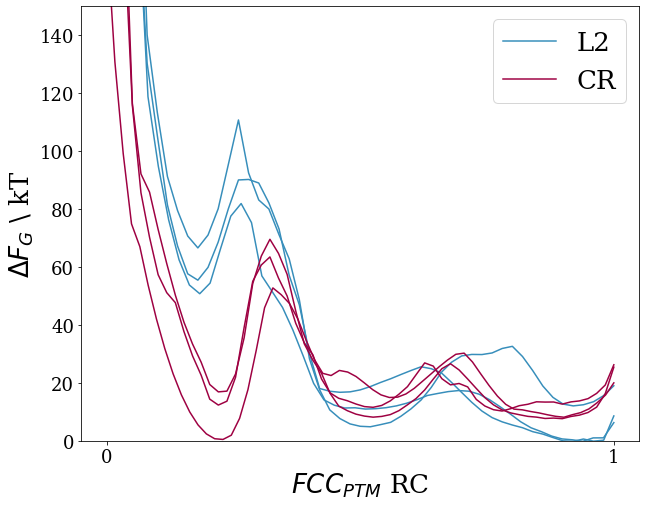

In [142]:
fig = plt.figure(figsize=(10, 8))

x = np.linspace(0,1,len(MEPL2_1))
plt.plot(x,MEPL2_1, color=cs["Blue"], label="L2")
x = np.linspace(0,1, len(MEPL2_2))
plt.plot(x,MEPL2_2, color=cs["Blue"])

x = np.linspace(0,1, len(MEPL2_3))
plt.plot(x,MEPL2_3, color=cs["Blue"])

x = np.linspace(0,1, len(MEPCR_1))
plt.plot(x,MEPCR_1, color=cs["Bordeaux"], label="CR")

x = np.linspace(0,1, len(MEPCR_2))
plt.plot(x,MEPCR_2, color=cs["Bordeaux"])

x = np.linspace(0,1, len(MEPCR_3))
plt.plot(x,MEPCR_3, color=cs["Bordeaux"])

plt.ylim(0,150)
plt.xticks([0,1])
plt.legend(fontsize=26)
#axs[0].set_xticklabels([0,1])
plt.xlabel("$FCC_{PTM}$ RC", fontsize=26)
plt.ylabel("$\Delta F_G$ \ kT", fontsize=26)
plt.savefig("Figs_paper/All_MEPs.png", dpi=500)

Text(0, 0.5, '$\\Delta F_G$ \\ kT')

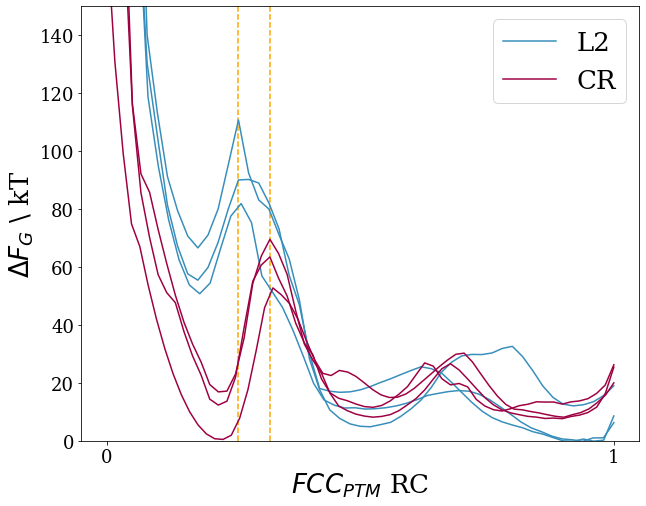

In [22]:
fig = plt.figure(figsize=(10, 8))

x = np.linspace(0,1,len(MEPL2_1))
plt.plot(x,MEPL2_1, color=cs["Blue"], label="L2")
plt.vlines(0.26, 0,150, linestyle="dashed", color="orange")

x = np.linspace(0,1, len(MEPL2_2))
plt.plot(x,MEPL2_2, color=cs["Blue"])

x = np.linspace(0,1, len(MEPL2_3))
plt.plot(x,MEPL2_3, color=cs["Blue"])

x = np.linspace(0,1, len(MEPCR_1))
plt.plot(x,MEPCR_1, color=cs["Bordeaux"], label="CR")
plt.vlines(0.3220339, 0,150, linestyle="dashed", color="orange")


x = np.linspace(0,1, len(MEPCR_2))
plt.plot(x,MEPCR_2, color=cs["Bordeaux"])

x = np.linspace(0,1, len(MEPCR_3))
plt.plot(x,MEPCR_3, color=cs["Bordeaux"])

plt.ylim(0,150)
plt.xticks([0,1])
plt.legend(fontsize=26)
#axs[0].set_xticklabels([0,1])
plt.xlabel("$FCC_{PTM}$ RC", fontsize=26)
plt.ylabel("$\Delta F_G$ \ kT", fontsize=26)